# Part 1: Introduction

The goal of our project is the understand what factors contribute to whether flights are delayed and the amount of time they are delayed for. Naturally, there are various reasons airlines may delay flights in consideration of the safety of passengers or otherwise. Inclement weather conditions are a common issue resulting in flight delays, and we are primarily interested in seeing whether weather characteristics such as temperature and precipitation can be used to predict delays. This information is quite useful as airlines are concerned with how they can maximize the number of passengers getting to their destinations. \
\
To this end, we used several datasets: `flights_df` with data on delays among other information for specific flights, `airports_loc_df` with data on location of airports, `airlines_df` with data matching airline codes to names, and `weather_df` with information about weather on a particular day at locations. Using all these datasets in conjunction with each other allow for information on the weather conditions at the departure airport for each flight on the day it departs.\
\
With this, we were able to employ various methods to gain an overall understanding of the data and aim to use factors to predict whether a particular flight will be delayed or not.

---

A full documentation of the data we used, relavent links and relavent schema

Flights were sourced from here: https://www.kaggle.com/datasets/usdot/flight-delays?select=flights.csv

Weather was sourced from here: https://asmith.ucdavis.edu/data/prism-weather

AirportLocations.csv was sourced from: https://geodata.bts.gov/datasets/usdot::aviation-facilities/about

For weather use the settings: Temporal unit should be daily, use county as spatial unit, start and end year are both 2015, months go from 1 to 12, states are all states, choose variables are tmin, tmax, tavg, ppt, dday_a5C, dday_b15C



# Part 2: Data Loading and Preprocessing

For this section, we load the necessary general libraries used. We then used joins to combine our datasets together. For a better understanding of what this entailed and what variables are involved in each dataset, please see the ER diagram below. This led to main combined dataset that we are using which is `result_important_df`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import kagglehub
import seaborn as sns

State regions were determined by the following image (kind of arbitrary). We decided to set AK to north and HI to pacific, this is here for the purpose of hypothesis testing later on.

![Alt Text](region.png)

In [2]:
state_to_region_dict = {
    'WA': 'northwest',
    'OR': 'northwest',
    'ID': 'northwest',
    'MT': 'northwest',
    'WY': 'northwest',
    'CA': 'west',
    'NV': 'west',
    'UT': 'southwest',
    'AZ': 'southwest',
    'CO': 'southwest',
    'NM': 'southwest',
    'TX': 'southwest',
    'OK': 'southwest',
    'ND': 'midwest',
    'SD': 'midwest',
    'NE': 'midwest',
    'KS': 'midwest',
    'MN': 'midwest',
    'IA': 'midwest',
    'MO': 'midwest',
    'WI': 'midwest',
    'IL': 'midwest',
    'MI': 'midwest',
    'KY': 'midwest',
    'IN': 'midwest',
    'OH': 'midwest',
    'AR': 'southeast',
    'LA': 'southeast',
    'MS': 'southeast',
    'AL': 'southeast',
    'GA': 'southeast',
    'FL': 'southeast',
    'TN': 'southeast',
    'NC': 'southeast',
    'SC': 'southeast',
    'VA': 'midatlantic',
    'WV': 'midatlantic',
    'MD': 'midatlantic',
    'DE': 'midatlantic',
    'DC': 'midatlantic',
    'NJ': 'midatlantic',
    'PA': 'midatlantic',
    'NY': 'midatlantic',
    'CT': 'newengland',
    'RI': 'newengland',
    'MA': 'newengland',
    'NH': 'newengland',
    'VT': 'newengland',
    'ME': 'newengland',
    'AK': 'north',
    'HI': 'pacific'
}

In [3]:
flights_df = pl.read_csv('flights.csv')
flights_df = flights_df.sample(fraction = 0.3, with_replacement=False, seed = 42)
airport_loc_df = pl.read_csv('AirportLocations.csv')
airlines_df = pl.read_csv('airlines.csv')
weather_df = pl.read_csv('weather.csv')

### ER Diagram

This entity relationship diagram is based on the 4 datasets we are using. Namely, the entities below correspond to the dataframes as follows: flight (flight_df), airport (airport_loc_df), airline (airlines_df), weather (weather_df). The relationships that exist are as follows:
- A flight departs from/arrives at exactly 1 aiport (respectively). An airport can be the departure location/arrival location of multiple flights.
- A flight is operated by exaclty 1 airline. An airline may operate multiple flights.
- An airport experiences various weather conditions (on different days). A specific weather condition on a specific day is experienced by exactly 1 airport.

For this last relationship, we assume that all (location, date) pairs are different, and that there is only 1 airport located in each county. That is, weather conditions at a specific location (and hence corresponding to a specific airport) are unique.

Note: Some attributes are left off of the flight entity (AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY) as they were not used going forward and the "CANCELLATION_REASON" column essentially had the same information.

![Alt Text](project_er_diagram.png)

Creating separate dataframes for flights that are delayed vs. those that are not that may be of interest later.

In [4]:
# delays_df = flights_df.filter(pl.col("DEPARTURE_DELAY") > 0)
# ontime_df = flights_df.filter(pl.col("DEPARTURE_DELAY") <= 0)

Here we are joining the county information so that we can compare weather conditions at the origin airport of each flight. Then, we are creating a datetime based on the three columns of 'YEAR', 'MONTH', and 'DAY' to allow for ease of joining with the weather dataset that has this format.

In [5]:
airport_loc_df = airport_loc_df.select(["ARPT_ID", "COUNTY_NAME", "STATE_CODE"])
flights_df = flights_df.join(
    airport_loc_df, 
    left_on="ORIGIN_AIRPORT", 
    right_on="ARPT_ID", 
    how="left"
)
flights_df = flights_df.with_columns(
    pl.datetime(
        year=pl.col("YEAR"), 
        month=pl.col("MONTH"), 
        day=pl.col("DAY")
    ).cast(pl.Date).alias("date")
)
flights_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date
2015,3,2,1,"""WN""",459,"""N902WN""","""ATL""","""BWI""",1800,1853,53,9,1902,105,99,86,577,2028,4,1945,2032,47,0,0,null,0,0,21,26,0,"""FULTON""","""GA""",2015-03-02
2015,4,20,1,"""EV""",4112,"""N11187""","""IAH""","""DSM""",1540,1609,29,12,1621,135,130,111,802,1812,7,1755,1819,24,0,0,null,0,0,24,0,0,"""HARRIS""","""TX""",2015-04-20
2015,7,15,3,"""UA""",742,"""N419UA""","""DEN""","""OMA""",2216,2228,12,26,2254,88,91,62,472,56,3,44,59,15,0,0,null,3,0,1,11,0,"""DENVER""","""CO""",2015-07-15
2015,1,6,2,"""B6""",62,"""N618JB""","""PBI""","""LGA""",1045,1058,13,11,1109,164,184,147,1035,1336,26,1329,1402,33,0,0,null,20,0,13,0,0,"""PALM BEACH""","""FL""",2015-01-06
2015,3,28,6,"""AA""",901,"""N4XCAA""","""DFW""","""PNS""",1325,1328,3,10,1338,108,95,81,604,1459,4,1513,1503,-10,0,0,null,null,null,null,null,null,"""TARRANT""","""TX""",2015-03-28
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,3,29,7,"""OO""",6325,"""N237SW""","""SAN""","""LAX""",1025,1059,34,22,1121,56,54,29,109,1150,3,1121,1153,32,0,0,null,32,0,0,0,0,"""SAN DIEGO""","""CA""",2015-03-29
2015,12,20,7,"""DL""",1729,"""N595NW""","""DTW""","""SFO""",2015,2200,105,28,2228,317,324,290,2079,18,6,2232,24,112,0,0,null,107,0,0,5,0,"""WAYNE""","""MI""",2015-12-20
2015,7,14,2,"""DL""",2358,"""N349NB""","""FAR""","""MSP""",505,500,-5,10,510,61,53,39,223,549,4,606,553,-13,0,0,null,null,null,null,null,null,"""CASS""","""ND""",2015-07-14


(Don't run the below cell more than once) Next, we further format the 'date' and 'county_name' columns of weather_df to match that of flights_df.

In [6]:
weather_df = weather_df.with_columns(
    pl.col("date").cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").alias("date")
)
weather_df = weather_df.with_columns(
    pl.col("county_name").str.to_lowercase().alias("county_name")
)
weather_df

st_abb,st_code,county_name,fips,date,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C
str,i64,str,i64,date,str,f64,f64,f64,f64,f64,f64
"""AL""",1,"""autauga""",1001,2015-01-01,"""stable""",-0.835,10.961,5.063,0.059,1.909,9.937
"""AL""",1,"""autauga""",1001,2015-01-02,"""stable""",0.276,13.216,6.746,3.863,3.008,8.254
"""AL""",1,"""autauga""",1001,2015-01-03,"""stable""",8.511,12.552,10.531,14.217,5.532,4.469
"""AL""",1,"""autauga""",1001,2015-01-04,"""stable""",12.328,20.585,16.457,48.919,11.456,0.668
"""AL""",1,"""autauga""",1001,2015-01-05,"""stable""",2.642,15.865,9.254,0.0,4.684,5.841
…,…,…,…,…,…,…,…,…,…,…,…
"""WY""",56,"""weston""",56045,2015-12-27,"""stable""",-19.242,-6.704,-12.973,0.0,0.0,27.973
"""WY""",56,"""weston""",56045,2015-12-28,"""stable""",-18.188,-2.366,-10.277,0.0,0.0,25.277
"""WY""",56,"""weston""",56045,2015-12-29,"""stable""",-20.651,-3.123,-11.887,0.0,0.0,26.887


Cross Referenced Data from here in order to ensure that the temperatures were correctly aligned: https://www.timeanddate.com/weather/usa/new-york/historic?month=12&year=2015

Then, we joined the flights_df with weather_df on the date and both county name and state to have the weather conditions at a particular airport on a particular day. We initially only merged on date and county name. However, upon realizing that there were cases with counties of the same name in different states, we also included state to also be merged to create result_df overall.

In [7]:
flights_df = flights_df.with_columns(
    pl.col("COUNTY_NAME").str.to_lowercase().alias("COUNTY_NAME")
)

result_df = flights_df.join(
    weather_df,
    left_on=["COUNTY_NAME", "date", "STATE_CODE"],
    right_on=["county_name", "date", "st_abb"],
    how="left"
)

flights_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date
2015,3,2,1,"""WN""",459,"""N902WN""","""ATL""","""BWI""",1800,1853,53,9,1902,105,99,86,577,2028,4,1945,2032,47,0,0,null,0,0,21,26,0,"""fulton""","""GA""",2015-03-02
2015,4,20,1,"""EV""",4112,"""N11187""","""IAH""","""DSM""",1540,1609,29,12,1621,135,130,111,802,1812,7,1755,1819,24,0,0,null,0,0,24,0,0,"""harris""","""TX""",2015-04-20
2015,7,15,3,"""UA""",742,"""N419UA""","""DEN""","""OMA""",2216,2228,12,26,2254,88,91,62,472,56,3,44,59,15,0,0,null,3,0,1,11,0,"""denver""","""CO""",2015-07-15
2015,1,6,2,"""B6""",62,"""N618JB""","""PBI""","""LGA""",1045,1058,13,11,1109,164,184,147,1035,1336,26,1329,1402,33,0,0,null,20,0,13,0,0,"""palm beach""","""FL""",2015-01-06
2015,3,28,6,"""AA""",901,"""N4XCAA""","""DFW""","""PNS""",1325,1328,3,10,1338,108,95,81,604,1459,4,1513,1503,-10,0,0,null,null,null,null,null,null,"""tarrant""","""TX""",2015-03-28
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,3,29,7,"""OO""",6325,"""N237SW""","""SAN""","""LAX""",1025,1059,34,22,1121,56,54,29,109,1150,3,1121,1153,32,0,0,null,32,0,0,0,0,"""san diego""","""CA""",2015-03-29
2015,12,20,7,"""DL""",1729,"""N595NW""","""DTW""","""SFO""",2015,2200,105,28,2228,317,324,290,2079,18,6,2232,24,112,0,0,null,107,0,0,5,0,"""wayne""","""MI""",2015-12-20
2015,7,14,2,"""DL""",2358,"""N349NB""","""FAR""","""MSP""",505,500,-5,10,510,61,53,39,223,549,4,606,553,-13,0,0,null,null,null,null,null,null,"""cass""","""ND""",2015-07-14


This next part filters out values where 'tavg' is null to basically drop rows without temperature data. We also create a new column called 'TOTAL_DELAY' that is a measure of the overall delay based on summing the 'DEPARTURE_DELAY' and 'ARRIVAL_DELAY' for a flight, this creates the result_important_df that we will use going forward.

In [8]:
result_important_df = result_df.filter(pl.col('tavg').is_not_null())
result_important_df = result_important_df.with_columns(
    (pl.col('DEPARTURE_DELAY') + pl.col('ARRIVAL_DELAY')).alias('TOTAL_DELAY')
)
result_important_df

YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date,st_code,fips,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY
i64,i64,i64,i64,str,i64,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,str,str,date,i64,i64,str,f64,f64,f64,f64,f64,f64,i64
2015,3,2,1,"""WN""",459,"""N902WN""","""ATL""","""BWI""",1800,1853,53,9,1902,105,99,86,577,2028,4,1945,2032,47,0,0,null,0,0,21,26,0,"""fulton""","""GA""",2015-03-02,13,13121,"""stable""",2.509,8.124,5.316,1.445,1.058,9.684,100
2015,4,20,1,"""EV""",4112,"""N11187""","""IAH""","""DSM""",1540,1609,29,12,1621,135,130,111,802,1812,7,1755,1819,24,0,0,null,0,0,24,0,0,"""harris""","""TX""",2015-04-20,48,48201,"""stable""",15.362,29.678,22.52,11.637,17.52,0.0,53
2015,7,15,3,"""UA""",742,"""N419UA""","""DEN""","""OMA""",2216,2228,12,26,2254,88,91,62,472,56,3,44,59,15,0,0,null,3,0,1,11,0,"""denver""","""CO""",2015-07-15,8,8031,"""stable""",13.796,31.057,22.427,4.988,17.427,0.135,27
2015,1,6,2,"""B6""",62,"""N618JB""","""PBI""","""LGA""",1045,1058,13,11,1109,164,184,147,1035,1336,26,1329,1402,33,0,0,null,20,0,13,0,0,"""palm beach""","""FL""",2015-01-06,12,12099,"""stable""",17.881,26.154,22.018,0.062,17.017,0.0,46
2015,3,28,6,"""AA""",901,"""N4XCAA""","""DFW""","""PNS""",1325,1328,3,10,1338,108,95,81,604,1459,4,1513,1503,-10,0,0,null,null,null,null,null,null,"""tarrant""","""TX""",2015-03-28,48,48439,"""stable""",7.415,21.363,14.389,0.0,9.389,2.534,-7
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,3,29,7,"""OO""",6325,"""N237SW""","""SAN""","""LAX""",1025,1059,34,22,1121,56,54,29,109,1150,3,1121,1153,32,0,0,null,32,0,0,0,0,"""san diego""","""CA""",2015-03-29,6,6073,"""stable""",10.428,28.597,19.512,0.0,14.512,1.001,66
2015,12,20,7,"""DL""",1729,"""N595NW""","""DTW""","""SFO""",2015,2200,105,28,2228,317,324,290,2079,18,6,2232,24,112,0,0,null,107,0,0,5,0,"""wayne""","""MI""",2015-12-20,26,26163,"""stable""",-5.675,-0.322,-2.999,0.0,0.0,17.999,217
2015,7,14,2,"""DL""",2358,"""N349NB""","""FAR""","""MSP""",505,500,-5,10,510,61,53,39,223,549,4,606,553,-13,0,0,null,null,null,null,null,null,"""cass""","""ND""",2015-07-14,38,38017,"""stable""",18.283,28.108,23.196,1.011,18.195,0.0,-18


# Part 3: Exploratory Data Analysis

We will now split in to test and train sets and proceed with EDA on the train set. As an overview, we first looked at general characteristics of the dataset such as summary statistics and datatypes. Then, we plotted the distributions of the delays using histograms and box plots, which included grouping via factors such as which month of year it was and which region (as determined by aforementioned map). We also looked for correlations between possible predictor variables and displayed results in a couple heatmaps. A few general graphs on airport and airline distribution are also included.

In [9]:
from sklearn.model_selection import train_test_split

target = ['DEPARTURE_DELAY']

X_train, X_test = train_test_split(result_important_df, test_size=0.2, random_state=0)
print(X_train.shape)
print(X_test.shape)

(1184302, 44)
(296076, 44)


Let us now get some understanding of what our data looks like, we first look at some statistics. For a brief overview, there are probably some variables that will matter less/more than others. To note a few things
- YEAR is always 2015 since that is the year we are considering, and specific times like TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN may not be as needed if we have DEPARTURE_TIME and ARRIVAL_TIME already.
- CANCELLATION_REASON is good for reference. There are reasons A, B, C, D that correspond to A - Airline/Carrier; B - Weather; C - National Air System; D - Security, so this is interesting to note. The five columns following that give similar information.
- There seem to be a lot of null values so it would be likely that we have to do some dropping of nulls/nans later
- DEPARTURE_DELAY ranges from -68 to 1878 minutes (more than a day) so there is a very wide range here, though the standard deviation is around 37, not as drastic
- There are some boolean variables diverted and cancelled that can be considered in addition to the delays.

In [10]:
basic_stats = X_train.describe()
basic_stats

statistic,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date,st_code,fips,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY
str,f64,f64,f64,f64,str,f64,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,f64,f64
"""count""",1.184302e6,1.184302e6,1.184302e6,1.184302e6,"""1184302""",1.184302e6,"""1181280""","""1184302""","""1184302""",1.184302e6,1.16546e6,1.16546e6,1.164861e6,1.164861e6,1.1843e6,1.161481e6,1.161481e6,1.184302e6,1.164112e6,1.164112e6,1.184302e6,1.164112e6,1.161481e6,1.184302e6,1.184302e6,"""19623""",225127.0,225127.0,225127.0,225127.0,225127.0,"""1184302""","""1184302""","""1184302""",1.184302e6,1.184302e6,"""1184302""",1.184302e6,1.184302e6,1.184302e6,1.184302e6,1.184302e6,1.184302e6,1.161481e6
"""null_count""",0.0,0.0,0.0,0.0,"""0""",0.0,"""3022""","""0""","""0""",0.0,18842.0,18842.0,19441.0,19441.0,2.0,22821.0,22821.0,0.0,20190.0,20190.0,0.0,20190.0,22821.0,0.0,0.0,"""1164679""",959175.0,959175.0,959175.0,959175.0,959175.0,"""0""","""0""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,22821.0
"""mean""",2015.0,6.209141,15.681943,3.917319,null,2244.059417,null,null,null,1327.615889,1334.143888,9.950581,16.187075,1356.188757,140.371214,135.725733,112.126556,809.529413,1472.685574,7.423587,1494.880135,1477.476219,5.017642,0.0027,0.016569,null,13.454006,0.074198,18.984675,23.513452,2.977142,null,null,"""2015-06-22 07:08:37.143000""",25.78574,25877.652383,null,9.964892,20.904825,15.43485,2.900942,11.713011,4.309375,14.890863
"""std""",0.0,3.383048,8.771762,1.992613,null,1770.581,null,null,null,482.925929,496.154864,37.467075,8.991747,497.738312,72.489279,71.655588,69.670187,583.058178,521.214579,5.710369,505.25893,525.453143,39.695613,0.051894,0.127651,null,27.895916,2.034412,47.804807,42.407529,20.716452,null,null,null,16.208545,16253.633012,null,10.153586,10.747313,10.281637,7.671848,8.051356,6.513636,75.904195
"""min""",2015.0,1.0,1.0,1.0,"""AA""",1.0,"""7819A""","""ABE""","""ABE""",1.0,1.0,-46.0,1.0,1.0,30.0,16.0,8.0,67.0,1.0,1.0,1.0,1.0,-82.0,0.0,0.0,"""A""",0.0,0.0,0.0,0.0,0.0,"""ada""","""AL""","""2015-01-01""",1.0,1045.0,"""stable""",-34.64,-24.915,-27.466,0.0,0.0,0.0,-104.0
"""25%""",2015.0,3.0,8.0,2.0,null,769.0,null,null,null,915.0,920.0,-5.0,11.0,935.0,86.0,83.0,61.0,373.0,1057.0,4.0,1111.0,1101.0,-13.0,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,null,null,"""2015-03-27""",12.0,12057.0,null,3.186,14.171,8.782,0.0,4.268,0.0,-17.0
"""50%""",2015.0,6.0,16.0,4.0,null,1752.0,null,null,null,1320.0,1328.0,-1.0,14.0,1341.0,121.0,118.0,94.0,646.0,1508.0,6.0,1520.0,1512.0,-5.0,0.0,0.0,null,2.0,0.0,2.0,4.0,0.0,null,null,"""2015-06-17""",25.0,25025.0,null,11.01,22.92,16.91,0.003,11.911,1.057,-6.0
"""75%""",2015.0,9.0,23.0,6.0,null,3351.0,null,null,null,1730.0,1740.0,8.0,19.0,1754.0,170.0,166.0,142.0,1042.0,1911.0,9.0,1916.0,1916.0,8.0,0.0,0.0,null,17.0,0.0,19.0,30.0,0.0,null,null,"""2015-09-06""",40.0,40143.0,null,18.228,29.196,23.645,1.639,18.645,6.338,15.0
"""max""",2015.0,12.0,31.0,7.0,"""WN""",7438.0,"""N9EAMQ""","""XNA""","""YUM""",2359.0,2400.0,1604.0,200.0,2400.0,718.0,715.0,671.0,4983.0,2400.0,180.0,2400.0,2400.0,1593.0,1.0,1.0,"""D""",862.0,364.0,1593.0,1010.0,1152.0,"""yellowstone""","""WY""","""2015-12-31""",56.0,56039.0,"""stable""",29.969,44.006,36.688,142.287,31.688,42.466,3197.0


The following is our schema. Most of the variables for the flight data are numerical integer values, while for weather we have floats. The string variables are those related to the airline, aiport, etc.

In [11]:
info = X_train.schema
info

Schema([('YEAR', Int64),
        ('MONTH', Int64),
        ('DAY', Int64),
        ('DAY_OF_WEEK', Int64),
        ('AIRLINE', String),
        ('FLIGHT_NUMBER', Int64),
        ('TAIL_NUMBER', String),
        ('ORIGIN_AIRPORT', String),
        ('DESTINATION_AIRPORT', String),
        ('SCHEDULED_DEPARTURE', Int64),
        ('DEPARTURE_TIME', Int64),
        ('DEPARTURE_DELAY', Int64),
        ('TAXI_OUT', Int64),
        ('WHEELS_OFF', Int64),
        ('SCHEDULED_TIME', Int64),
        ('ELAPSED_TIME', Int64),
        ('AIR_TIME', Int64),
        ('DISTANCE', Int64),
        ('WHEELS_ON', Int64),
        ('TAXI_IN', Int64),
        ('SCHEDULED_ARRIVAL', Int64),
        ('ARRIVAL_TIME', Int64),
        ('ARRIVAL_DELAY', Int64),
        ('DIVERTED', Int64),
        ('CANCELLED', Int64),
        ('CANCELLATION_REASON', String),
        ('AIR_SYSTEM_DELAY', Int64),
        ('SECURITY_DELAY', Int64),
        ('AIRLINE_DELAY', Int64),
        ('LATE_AIRCRAFT_DELAY', Int64),
        ('WEAT

### Looking for potential outliers and visualizing distributions
Although it is a lot more rare for flights to be delayed for amounts > a few hundred minutes, there is really a considerable amount of data points even at the higher end, so we did not decide to remove any outliers, as this should not affect a lot of our analysis that is based on delay as a boolean variable anyways.\
\
For instance, for departure delays, there are values at 1878, 1670, 1649, 1631, 1625, 1609, 1557, 1542, 1522, 1496, 1480, 1475, 1461, 1458, 1457, 1450, 1429, etc. minutes. So for the most part there is not clear separation of what would be a good cutoff. \
\
To better visualize the distributions, see the following graphs for DEPARTURE_DELAY, ARRIVAL_DELAY, and TOTAL_DELAY. It should also be noted that usually DEPARTURE_DELAY was very correlated with ARRIVAL_DELAY and TOTAL_DELAY was approximately twice the DEPARTURE_DELAY, which is approximately twice the ARRIVAL_DELAY. Note that delays can be both positive and negative, with negative delays meaning that a flight departed earlier than scheduled and positive delays meaning that a flight departed later than scheduled.

Text(0, 0.5, 'Count')

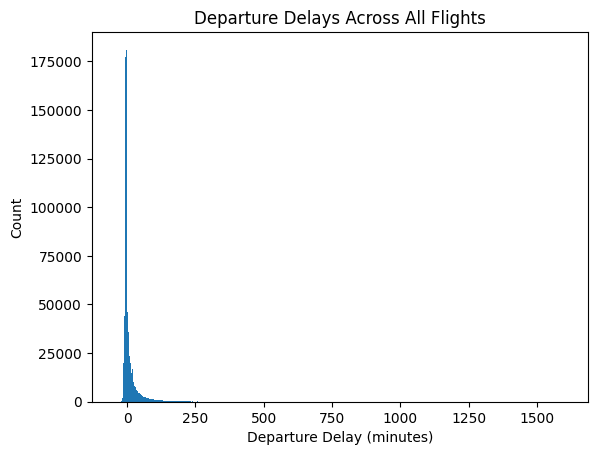

In [12]:
X_train['DEPARTURE_DELAY'].max()
_ = plt.hist(X_train['DEPARTURE_DELAY'], bins = 700)
plt.title("Departure Delays Across All Flights")
plt.xlabel("Departure Delay (minutes)")
plt.ylabel("Count")

Since it is true that the dataset is very right skewed, it may be of interest to consider just the delay amounts on the lower end since those are much more prevalent, so if we look at delays <= 15, we get the following distribution.

Text(0, 0.5, 'Count')

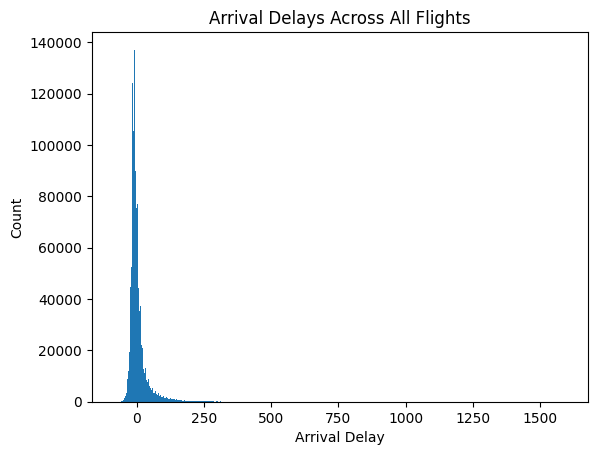

In [13]:
_ = plt.hist(X_train['ARRIVAL_DELAY'], bins = 500)
plt.title("Arrival Delays Across All Flights")
plt.xlabel("Arrival Delay")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

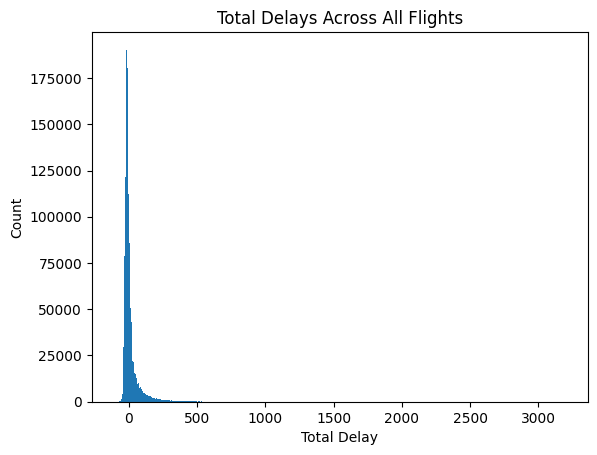

In [14]:
# Repeating the same for Total Delays
_ = plt.hist(X_train['TOTAL_DELAY'], bins = 500)
plt.title("Total Delays Across All Flights")
plt.xlabel("Total Delay")
plt.ylabel("Count")

Next, we looked at if there was any visible differences in delays across different months. There was nothing clearly discernable. Though perhaps for a month like December it looked like there were some more higher values outside of the box of the boxplot than a month like July. We also realized that the dataset for some reason did not contain any data for October. There is so much data outside these boxes and the data within the boxes is so concentrated that the boxes of the boxplots are barely visible.

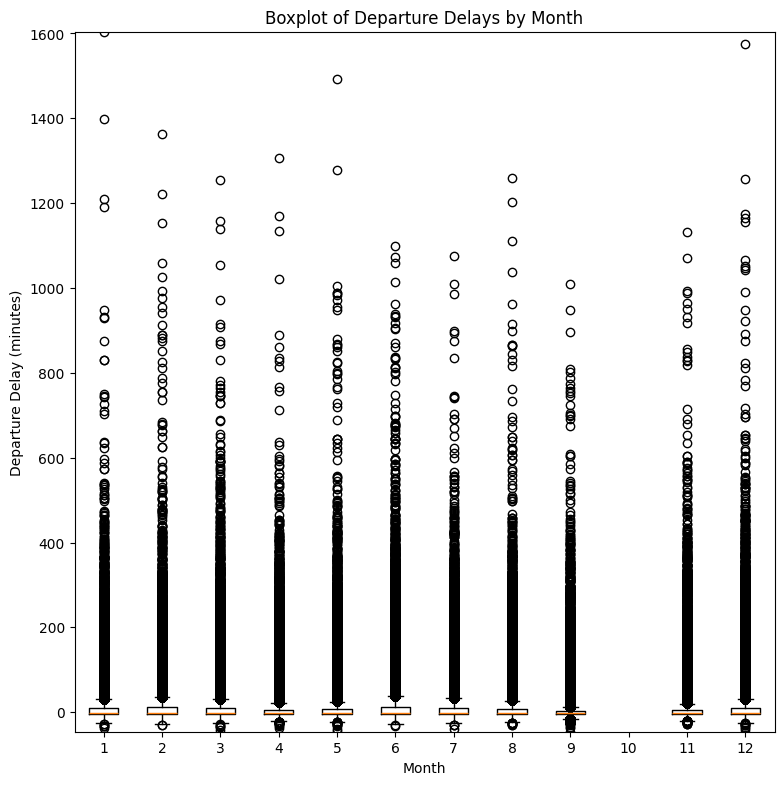

In [15]:
data1 = (X_train.filter(pl.col('MONTH') == 1)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data2 = (X_train.filter(pl.col('MONTH') == 2)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data3 = (X_train.filter(pl.col('MONTH') == 3)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data4 = (X_train.filter(pl.col('MONTH') == 4)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data5 = (X_train.filter(pl.col('MONTH') == 5)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data6 = (X_train.filter(pl.col('MONTH') == 6)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data7 = (X_train.filter(pl.col('MONTH') == 7)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data8 = (X_train.filter(pl.col('MONTH') == 8)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data9 = (X_train.filter(pl.col('MONTH') == 9)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data10 = (X_train.filter(pl.col('MONTH') == 10)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data11 = (X_train.filter(pl.col('MONTH') == 11)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
data12 = (X_train.filter(pl.col('MONTH') == 12)).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
boxplot_data = [data1.to_numpy().flatten(), data2.to_numpy().flatten(), data3.to_numpy().flatten(),
                data4.to_numpy().flatten(), data5.to_numpy().flatten(), data6.to_numpy().flatten(),
                data7.to_numpy().flatten(), data8.to_numpy().flatten(), data9.to_numpy().flatten(),
                data10.to_numpy().flatten(), data11.to_numpy().flatten(), data12.to_numpy().flatten()]
fig = plt.figure(figsize = (7, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(boxplot_data)
ax.set_ylim(X_train.select(pl.min("DEPARTURE_DELAY"))[0,0], X_train.select(pl.max("DEPARTURE_DELAY"))[0,0])
ax.set_title("Boxplot of Departure Delays by Month")
ax.set_xlabel("Month")
ax.set_ylabel("Departure Delay (minutes)")
plt.show()

We convert state_to_region_dict to a dataframe for joining purposes and join it with X_train to create X_train_region that has the regions corresponding to the states that the departure airport is associated with. The state_to_region_df created with also be used later on in testing Hypothesis 2.\
\
From this, we creates a boxplot of the data for each region. We realized that there was no data for any flights departing from Hawaii nor Alaska, thus there was no data for the regions "pacific" and "north". It was noticed that there were some observable differences in regions like the Northwest and New England having departure delays that were concentrated at lower values whereas for the rest of the regions there was a larger spread and also considerable amount of data points for longer departure delays.

In [16]:
state_to_region_df = pl.from_dict(state_to_region_dict)
states = pl.Series(state_to_region_df.columns)
state_to_region_df = state_to_region_df.transpose()
state_to_region_df = state_to_region_df.insert_column(1, states)
state_to_region_df.columns = ['region', 'STATE_CODE']

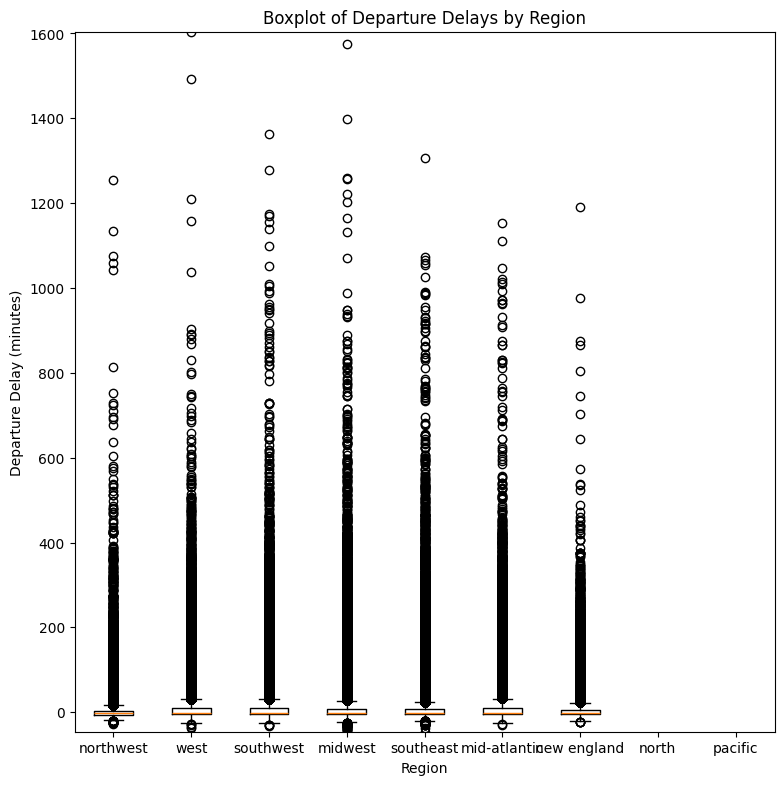

In [17]:
# Join X_train with this to add a new column with the regions
X_train_region = X_train.join(state_to_region_df, on = 'STATE_CODE', how = 'left')

nw = (X_train_region.filter(pl.col('region') == "northwest")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
w = (X_train_region.filter(pl.col('region') == "west")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
sw = (X_train_region.filter(pl.col('region') == "southwest")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
mw = (X_train_region.filter(pl.col('region') == "midwest")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
se = (X_train_region.filter(pl.col('region') == "southeast")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
ma = (X_train_region.filter(pl.col('region') == "midatlantic")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
ne = (X_train_region.filter(pl.col('region') == "newengland")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
n = (X_train_region.filter(pl.col('region') == "north")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
p = (X_train_region.filter(pl.col('region') == "pacific")).select(pl.col('DEPARTURE_DELAY').drop_nans().drop_nulls())
boxplot_data = [nw.to_numpy().flatten(), w.to_numpy().flatten(), sw.to_numpy().flatten(),
                mw.to_numpy().flatten(), se.to_numpy().flatten(), ma.to_numpy().flatten(),
                ne.to_numpy().flatten(), n.to_numpy().flatten(), p.to_numpy().flatten()]
fig = plt.figure(figsize = (7, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(boxplot_data)
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9], ['northwest', 'west', 'southwest', 'midwest', 'southeast', 'mid-atlantic', 'new england', 'north', 'pacific'])
ax.set_ylim(X_train.select(pl.min("DEPARTURE_DELAY"))[0,0], X_train.select(pl.max("DEPARTURE_DELAY"))[0,0])
ax.set_title("Boxplot of Departure Delays by Region")
ax.set_xlabel("Region")
ax.set_ylabel("Departure Delay (minutes)")
plt.show()

Below is a correlation matrix for specific columns of interest to observe for any correlation between potential predictor variables. It makes sense that factors like SCHEDULED_DEPARTURE and DEPARTURE_TIME, as well as between min/max/average temperatures to be highly correlated. The other main correlation that should be noted that is considerably high is between DEPARTURE_DELAY and ARRIVAL_DELAY. Although, along the lines of what we may be looking for, in possibly observing correlations between weather conditions and delays, there do not seem to be much correlation at all.

In [18]:
columns_of_interest = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'ELAPSED_TIME', 'AIR_TIME', 'WHEELS_ON', 'DISTANCE', 'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'tmin', 'tmax', 'tavg', 'ppt', 'dday_a5C', 'dday_b15C']
X_train_numerical = X_train.select(columns_of_interest)
df = X_train_numerical.to_pandas()
corr_matrix = df.corr()
corr_matrix

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,ELAPSED_TIME,AIR_TIME,WHEELS_ON,DISTANCE,ARRIVAL_DELAY,DIVERTED,CANCELLED,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C
SCHEDULED_DEPARTURE,1.000000,0.963041,0.115049,0.003079,0.936558,-0.034242,-0.031671,0.660559,-0.027265,0.105173,-0.002065,0.010701,0.019859,0.016116,0.018228,0.004885,0.016842,-0.018053
DEPARTURE_TIME,0.963041,1.000000,0.179218,0.010383,0.971489,-0.037786,-0.036630,0.680900,-0.033805,0.167123,0.000522,0.008127,0.016420,0.011047,0.013885,0.012714,0.014282,-0.012003
DEPARTURE_DELAY,0.115049,0.179218,1.000000,0.057183,0.170083,0.027616,0.019953,0.061352,0.020938,0.945231,0.022226,0.034587,0.003586,-0.013871,-0.005476,0.060064,0.011593,0.028300
TAXI_OUT,0.003079,0.010383,0.057183,1.000000,0.035774,0.209421,0.086441,0.027722,0.071394,0.228029,0.011562,0.002276,-0.054682,-0.089451,-0.073759,0.031678,-0.051834,0.092727
WHEELS_OFF,0.936558,0.971489,0.170083,0.035774,1.000000,-0.043173,-0.045561,0.701095,-0.045526,0.162964,0.000825,0.004626,0.014468,0.007371,0.011000,0.013843,0.012268,-0.008393
ELAPSED_TIME,-0.034242,-0.037786,0.027616,0.209421,-0.043173,1.000000,0.989068,0.027154,0.971938,0.032349,NaN,NaN,0.004416,-0.014863,-0.005584,-0.006787,-0.008243,0.001147
AIR_TIME,-0.031671,-0.036630,0.019953,0.086441,-0.045561,0.989068,1.000000,0.025005,0.984873,-0.005878,NaN,NaN,0.012184,-0.003011,0.004447,-0.011207,-0.001983,-0.012441
WHEELS_ON,0.660559,0.680900,0.061352,0.027722,0.701095,0.027154,0.025005,1.000000,0.022968,0.061063,0.006576,NaN,-0.000829,-0.004514,-0.002768,0.004045,-0.003635,0.000910
DISTANCE,-0.027265,-0.033805,0.020938,0.071394,-0.045526,0.971938,0.984873,0.022968,1.000000,-0.024650,0.014835,-0.034010,0.027706,0.019532,0.023888,-0.019775,0.013915,-0.034608
ARRIVAL_DELAY,0.105173,0.167123,0.945231,0.228029,0.162964,0.032349,-0.005878,0.061063,-0.024650,1.000000,NaN,NaN,0.000077,-0.015320,-0.007967,0.065364,0.010363,0.032224


Naturally as we are interested in DEPARTURE and ARRIVAL delay when choosing features, we should choose features that seem to be highly correlated with these delays
We will use 2 metrics that I think do a good job of measuring correlation, 1 is the standard pearson correlation, then to compare categorical values we will use the CramerV correlation metric

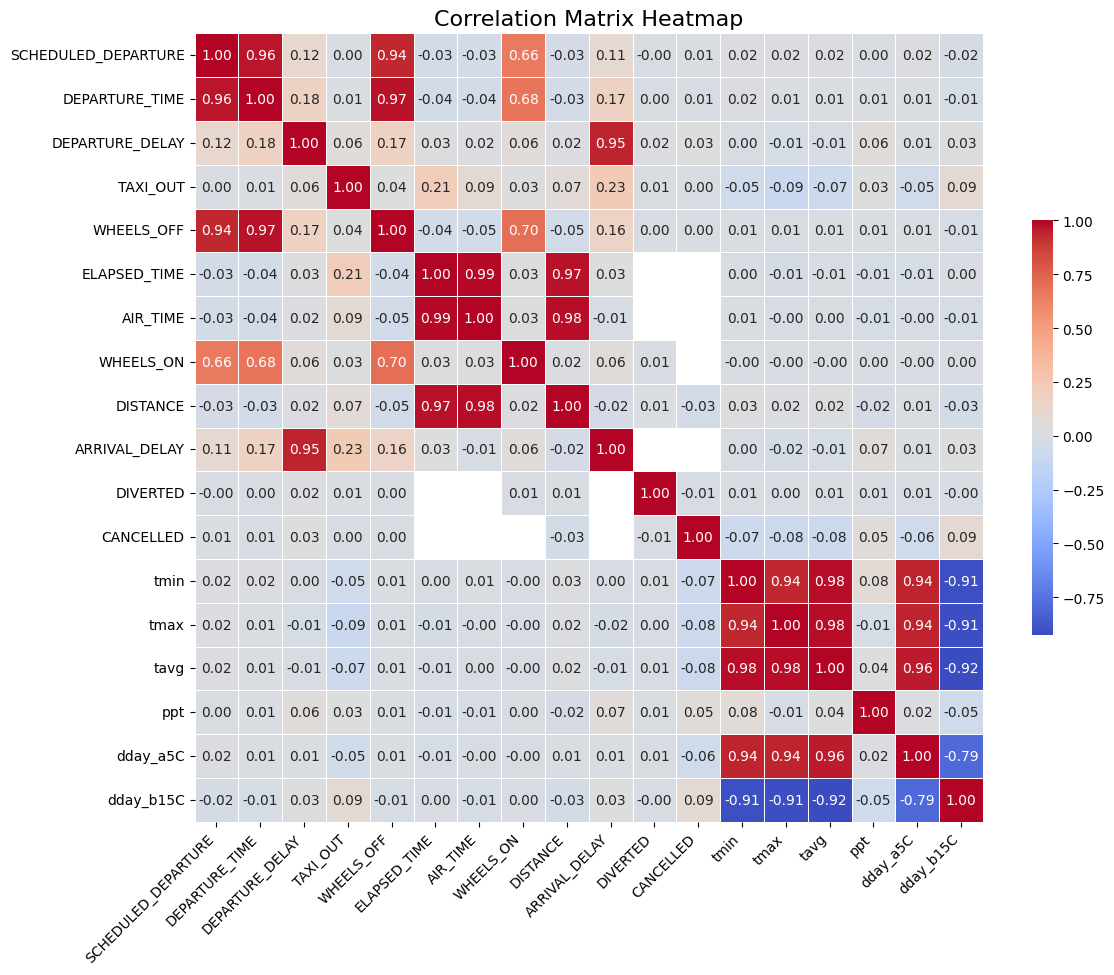

In [19]:
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


As we can see there are very weak correlations, but what if we filter for precipitation > 1? That is, if we consider days with very little precipitation to essentially be days of no precipitation. As shown below, we also did not find this to yield any observable correlations between factors like precipitation with the delay amounts.

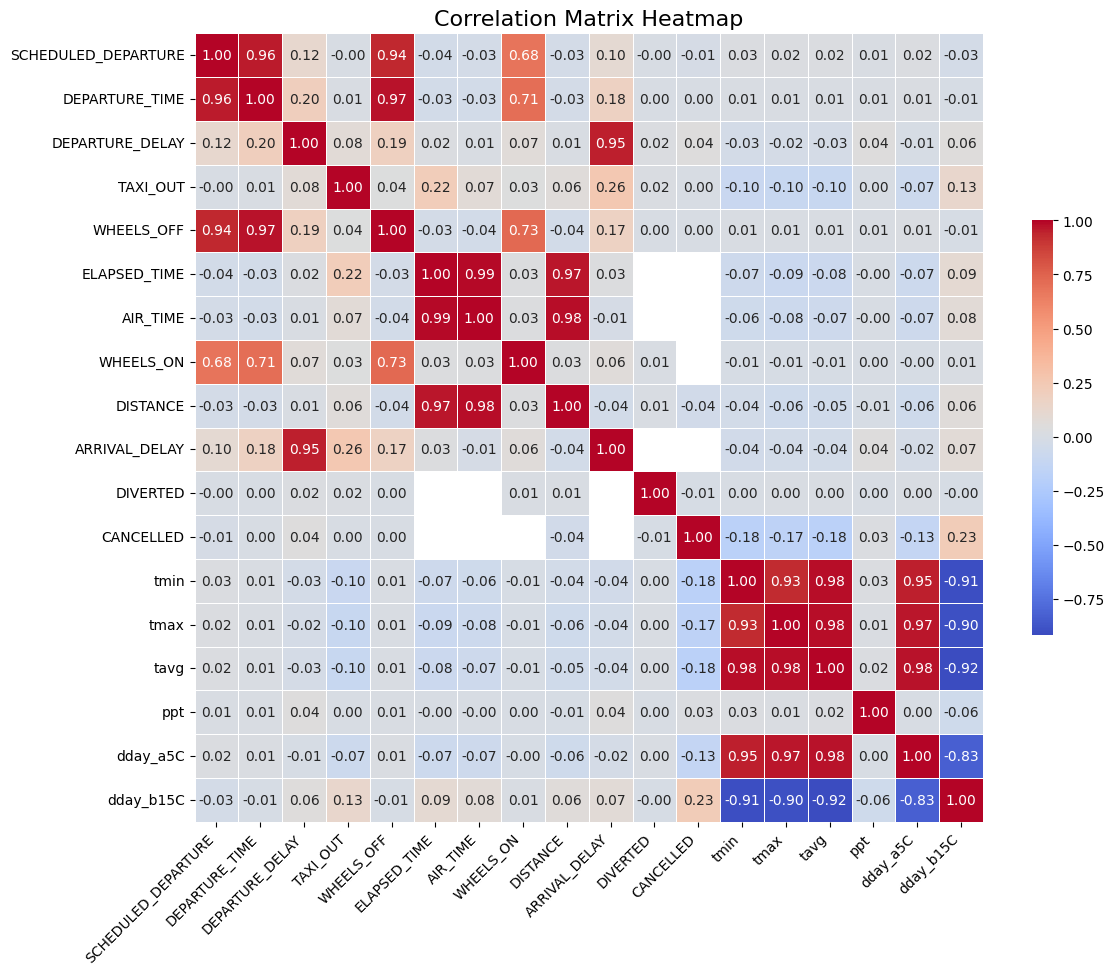

(184350, 18)


In [20]:
df_ppt_filtered = df[df['ppt'] > 5]
corr_matrix = df_ppt_filtered.corr()
plt.figure(figsize=(12, 10))

sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .5}
)

plt.title('Correlation Matrix Heatmap', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(df_ppt_filtered.shape)

The next visual we have is a bar graph showing the number of flights originating from each airport. Sorting this by flight count, we can notice that the top 5 airports (ATL, ORD, DFW, DEN, LAX) by flight count have relatively more than the rest, but after that the number of flights is roughly the same across the rest of the airports and gradually decrease. This gives us a sense the generation distribution of the data in terms of what locations might be considered, there do not seem to be any outliers or anything.

C:\Users\nball\AppData\Local\Temp\ipykernel_9648\2889801515.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  origin_counts = X_train.group_by("ORIGIN_AIRPORT").count()


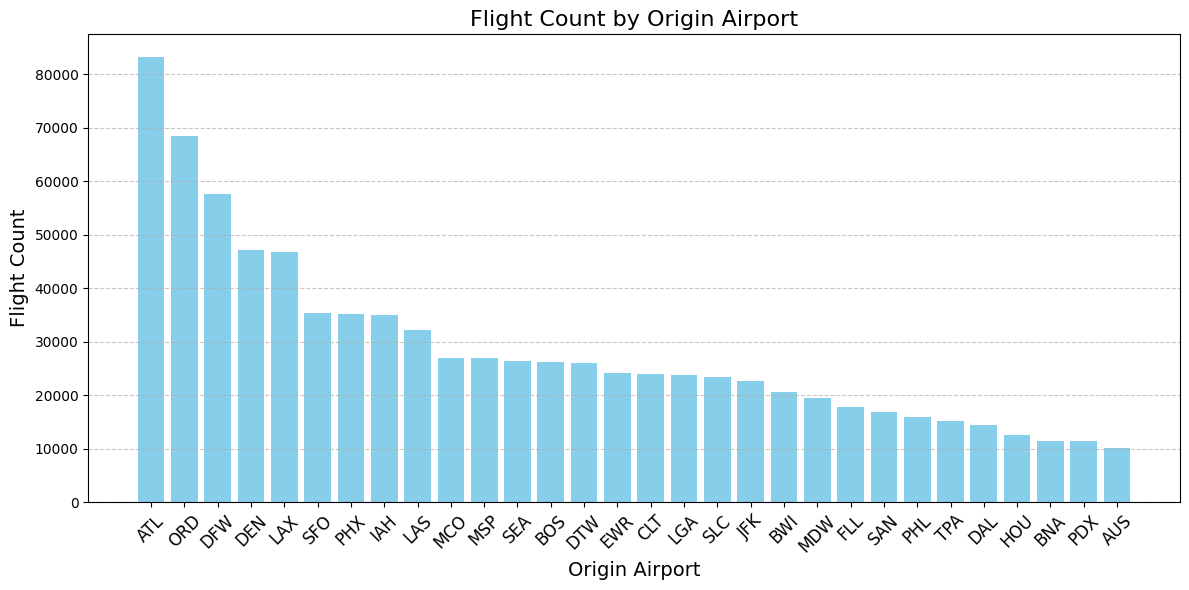

In [21]:
origin_counts = X_train.group_by("ORIGIN_AIRPORT").count()
origin_counts_pd = origin_counts.to_pandas()
origin_counts_pd = origin_counts_pd.sort_values(by="count", ascending=False)
top_30 = origin_counts_pd.head(30)

# Plot the bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_30["ORIGIN_AIRPORT"], top_30["count"], color="skyblue")
plt.xlabel("Origin Airport", fontsize=14)
plt.ylabel("Flight Count", fontsize=14)
plt.title("Flight Count by Origin Airport", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

We can also look at the number of flights for each particular airline in a similar bar graph. Sorting by count, we can also notice that certain airlines have a lot more flights than others (ex. WN - Southwest Airlines vs. HA - Hawaiian Airlines). This is further used later in testing Hypothesis 3 where we are potentially looking to see if certain airlines delay less/more flights on average.

C:\Users\nball\AppData\Local\Temp\ipykernel_9648\1305936786.py:1: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  airline_counts = X_train.group_by("AIRLINE").count()


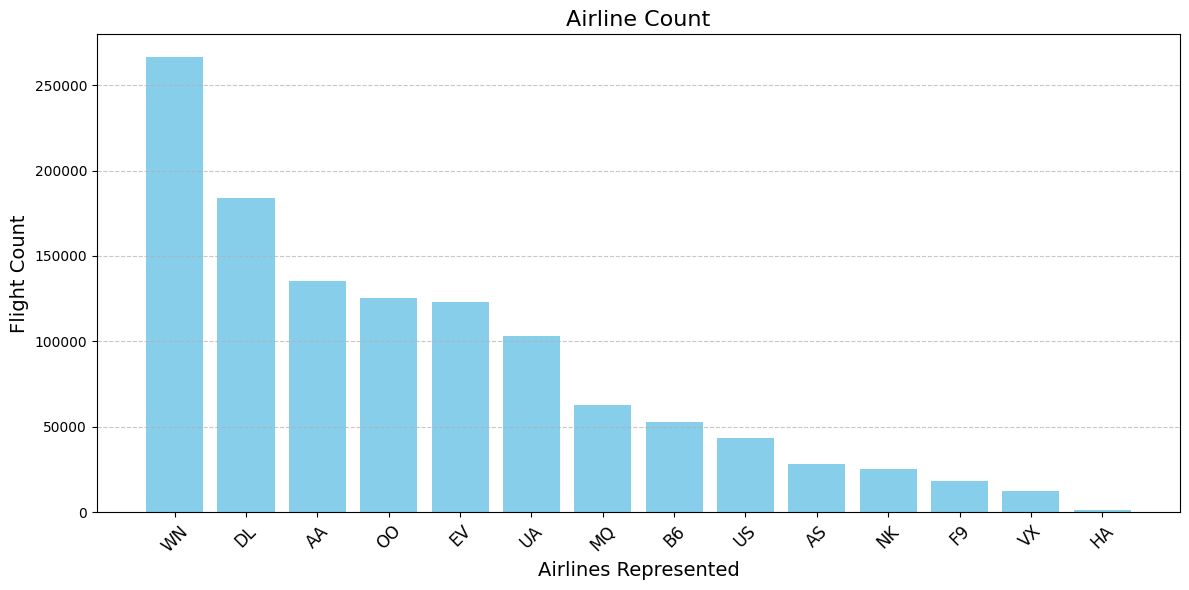

In [22]:
airline_counts = X_train.group_by("AIRLINE").count()
airline_counts = airline_counts.to_pandas()
airline_counts = airline_counts.sort_values(by="count", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(airline_counts["AIRLINE"], airline_counts["count"], color="skyblue")
plt.xlabel("Airlines Represented", fontsize=14)
plt.ylabel("Flight Count", fontsize=14)
plt.title("Airline Count", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

Now for some feature importance! We have a few modeling ideas

1) Given delay, weather, location, and other features in the dataframe, can we accurately predict which airline caused the delay

2) Conversely given an airline, weather, origin, destination, and other features, can we accurately predict the total delay (arrival + departure delay)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

target = ['DEPARTURE_DELAY']
y_train = X_train.select(target)
X_train_total_delay = X_train.drop(target)

non_numeric_cols = [col for col in X_train_total_delay.columns if X_train_total_delay[col].dtype == pl.Utf8]
encoded_non_numeric = X_train_total_delay
for col in non_numeric_cols:
    le = LabelEncoder()
    encoded_non_numeric = encoded_non_numeric.with_columns(
        pl.Series(name=col, values=le.fit_transform(encoded_non_numeric[col].to_list()))
    )
print(non_numeric_cols)
X_train_total_delay = encoded_non_numeric
X_train_total_delay = pl.concat([X_train_total_delay, y_train], how="horizontal")
X_train_total_delay_cleaned = X_train_total_delay.filter(
    pl.col("DEPARTURE_DELAY").is_not_null()
)

X_train_total_delay_cleaned = X_train_total_delay_cleaned.to_pandas()
X_train_total_delay_cleaned = X_train_total_delay_cleaned.dropna()
X_train_total_delay_cleaned = pl.DataFrame(X_train_total_delay_cleaned)
X_train_total_delay_cleaned

['AIRLINE', 'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'CANCELLATION_REASON', 'COUNTY_NAME', 'STATE_CODE', 'stability']


YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,COUNTY_NAME,STATE_CODE,date,st_code,fips,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY,DEPARTURE_DELAY
i64,i64,i64,i64,i64,i64,i32,i64,i64,i64,i64,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,f64,i64,i64,i32,f64,f64,f64,f64,f64,i64,i64,datetime[ms],i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64
2015,1,30,5,5,131,4404,74,79,1905,1940,14.0,1954.0,123.0,112.0,94.0,641,2028.0,4.0,2008,2032.0,24.0,0,0,4,0.0,0.0,0.0,24.0,0.0,222,40,2015-01-30 00:00:00,48,48439,0,5.62,19.707,12.663,0.0,7.664,3.535,59.0,35
2015,1,2,5,13,52,2104,123,75,1900,1927,9.0,1936.0,60.0,51.0,38.0,239,2014.0,4.0,2000,2018.0,18.0,0,0,4,0.0,0.0,3.0,15.0,0.0,94,40,2015-01-02 00:00:00,48,48201,0,4.993,8.113,6.553,4.461,1.553,8.447,45.0,27
2015,7,9,4,0,2285,1497,166,157,1840,1937,87.0,2104.0,169.0,245.0,147.0,944,2331.0,11.0,2129,2342.0,133.0,0,0,4,133.0,0.0,0.0,0.0,0.0,169,7,2015-07-09 00:00:00,12,12095,0,23.2,33.503,28.351,0.565,23.352,0.0,190.0,57
2015,9,3,4,13,1344,687,73,99,1115,1117,36.0,1153.0,230.0,244.0,199.0,1605,1712.0,9.0,1705,1721.0,16.0,0,0,4,16.0,0.0,0.0,0.0,0.0,59,4,2015-09-03 00:00:00,8,8031,0,16.869,32.348,24.609,0.0,19.608,0.0,18.0,2
2015,4,8,3,10,1573,402,73,99,1250,1328,17.0,1345.0,233.0,271.0,241.0,1605,1946.0,13.0,1843,1959.0,76.0,0,0,4,38.0,0.0,0.0,0.0,38.0,59,4,2015-04-08 00:00:00,8,8031,0,5.798,18.39,12.094,0.0,7.094,3.675,114.0,38
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2015,6,21,7,0,335,1950,197,207,1359,1419,28.0,1447.0,93.0,90.0,58.0,334,1545.0,4.0,1532,1549.0,17.0,0,0,4,0.0,0.0,2.0,15.0,0.0,46,11,2015-06-21 00:00:00,17,17031,0,15.514,26.32,20.917,9.43,15.917,0.0,37.0,20
2015,6,16,2,9,2826,1692,197,143,2030,2108,23.0,2131.0,126.0,114.0,86.0,588,2257.0,5.0,2236,2302.0,26.0,0,0,4,0.0,0.0,0.0,26.0,0.0,46,11,2015-06-16 00:00:00,17,17031,0,16.912,27.13,22.021,47.086,17.021,0.0,64.0,38
2015,2,28,6,9,5294,4463,235,167,1656,1742,15.0,1757.0,52.0,54.0,24.0,89,1821.0,15.0,1748,1836.0,48.0,0,0,4,2.0,0.0,46.0,0.0,0.0,204,3,2015-02-28 00:00:00,6,6083,0,6.068,16.652,11.36,0.047,6.36,3.922,94.0,46


In [24]:

target = ['DEPARTURE_DELAY']
y_train = X_train_total_delay_cleaned.select(target)
X_train_total_delay = X_train_total_delay_cleaned.drop(target)
X_train_total_delay = X_train_total_delay.with_columns(
    [pl.col(column).cast(pl.Int32) for column in X_train_total_delay.columns if X_train_total_delay[column].dtype == pl.Int64]
)
X_train_total_delay = X_train_total_delay.with_columns(
    [pl.col(column).cast(pl.Float32) for column in X_train_total_delay.columns if X_train_total_delay[column].dtype == pl.Float64]
)

174557
50570
R^2 Score: 0.030983477238863077


C:\Users\nball\AppData\Local\Temp\ipykernel_9648\3825093311.py:21: RuntimeWarning: divide by zero encountered in log
  y_train_np = np.where(y_train_np > 0, np.log(y_train_np), np.log(1e-9))
C:\Users\nball\AppData\Local\Temp\ipykernel_9648\3825093311.py:21: RuntimeWarning: invalid value encountered in log
  y_train_np = np.where(y_train_np > 0, np.log(y_train_np), np.log(1e-9))


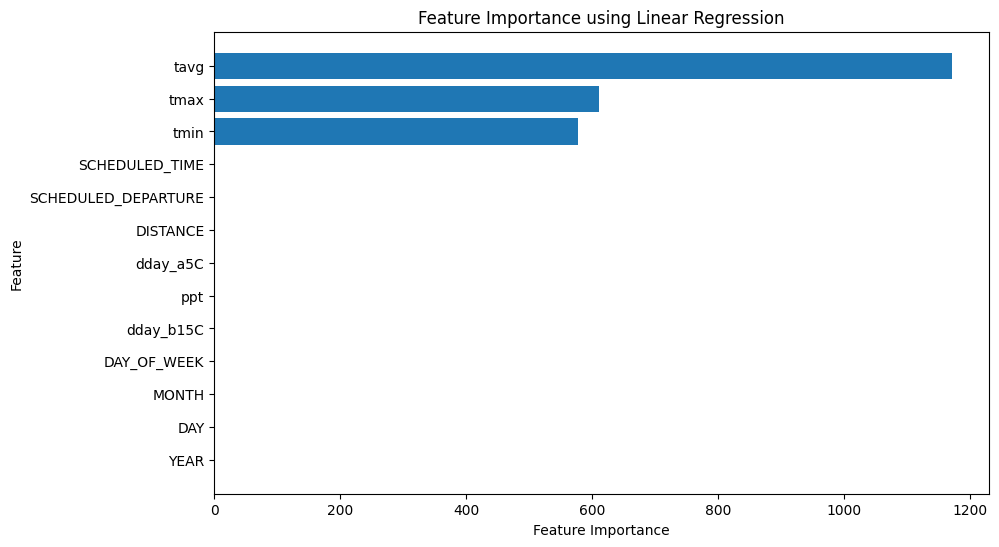

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

numeric_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"]

scaler = StandardScaler()
X_standardized_np = scaler.fit_transform(X_train_total_delay.to_numpy())


X_standardized = pl.DataFrame(
    X_standardized_np,
    schema=X_train_total_delay.columns
)
print(len(y_train.filter(y_train["DEPARTURE_DELAY"] > 15)))
print(len(y_train.filter(y_train["DEPARTURE_DELAY"] <= 15)))
X_standardized_pd = X_standardized.to_pandas()
X_standardized_pd = X_standardized_pd[numeric_features]

y_train_np = y_train.to_numpy()
y_train_np = np.where(y_train_np > 0, np.log(y_train_np), np.log(1e-9))

lr = LinearRegression()
lr.fit(X_standardized_pd, y_train_np)
y_pred = lr.predict(X_standardized_pd)
r2 = r2_score(y_train_np, y_pred)
print(f"R^2 Score: {r2}")

coefficients = lr.coef_.ravel() if len(lr.coef_.shape) > 1 else lr.coef_

feature_importances = pd.DataFrame({
    "Feature": X_standardized_pd.columns,
    "Importance": np.abs(coefficients)
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances["Feature"], feature_importances["Importance"])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance using Linear Regression")
plt.gca().invert_yaxis()
plt.show()

# Part 4: Hypothesis Testing

Now it is time to move into some hypothesis testing

We will be looking at the following hypotheses all tested with $\alpha = 0.05$ for significance:

1) When precipitation is greater than 1 is a flight more likely to be delayed?

$H_0$: When precipitation is greater than 1 a flight has the same likelihood of being delayed

2) Are flights in western, southwestern, and southeastern states less likely to be delayed than states in the midwest, new england, mid-atlantic, and northwest in winter months?

$H_0$: Western, southwestern, and southeastern states are delayed the same amount as flights in the midwest, new england, mid-atlantic, and the northwest in winter months.

3) Some of us have had some bad experience with certain airlines (looking at you AA), is this the truth, are some airlines significantly more likely to have delays than others?

$H_0$: all airlines experience the same average delay

### Hypothesis 1

We want to test a population proportion in looking at the proportion of flights that are delayed (as a boolean value). So, in comparing the cases where precipitation is greater than 1 or < 1 (essentially, whether there is noticeable precipitation or not), we would be testing a difference of population proportions. The other option would be to test whether the difference by considering the actual number of minutes (i.e. the mean delay time), though we decided to use the boolean method instead. We can formulate specifically\
\
$H_0$ = p_precip - p_noprecip = 0\
$H_1$ = p_precip - p_noprecip > 0

In [26]:
precip_df = result_important_df.filter(pl.col("ppt") > 1)
noprecip_df = result_important_df.filter(pl.col("ppt") <= 1)

In [27]:
# Create a new column "IS_DELAYED" that's 1 if delayed and 0 if on time
precip_df = precip_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
noprecip_df = noprecip_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
delay_precip_proportion = precip_df.select(pl.sum('IS_DELAYED')) / len(precip_df)
delay_noprecip_proportion = noprecip_df.select(pl.sum('IS_DELAYED')) / len(noprecip_df)

# Calculate original test statistic (0.420968 - 0.354947 = 0.066021)
delay_proportion_diff = delay_precip_proportion[0, 0] - delay_noprecip_proportion[0, 0]

# Simulate the null world - same proportion of flights being delayed regardless of precipitation, 10,000,000 trials each
simulated_delays_precip = np.random.binomial(len(precip_df), 0.5, 10_000_000) / len(precip_df)
simulated_delays_noprecip = np.random.binomial(len(noprecip_df), 0.5, 10_000_000) / len(noprecip_df)
simulated_precip_proportion = sum(simulated_delays_precip) / len(simulated_delays_precip)
simulated_noprecip_proportion = sum(simulated_delays_noprecip) / len(simulated_delays_noprecip)
# simulated values: (0.500 - 0.499 = -3.615e-08)
simulated_proportion_diff = simulated_precip_proportion - simulated_noprecip_proportion

# Calculate the p-value (p = 0)
simulated_p_value = sum(x >= delay_proportion_diff for x in (simulated_delays_precip - simulated_delays_noprecip)) / len(simulated_delays_precip)

Since p = 0 < 0.05, we reject the null hypothesis the the proportion of delayed flights on days with precipitation > 1 is the same as when precipitation <= 1.

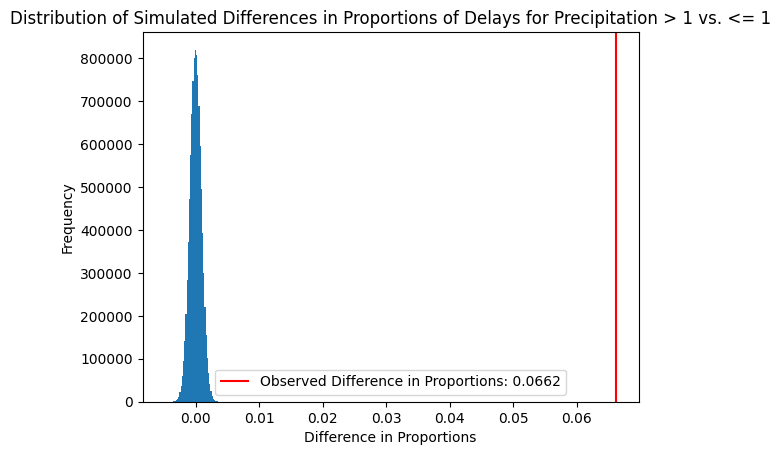

In [28]:
# Plot the distribution of simulated difference in proportions of delays for precipitation > 1 vs. <= 1
_ = plt.hist(simulated_delays_precip - simulated_delays_noprecip, bins = 50)
plt.title("Distribution of Simulated Differences in Proportions of Delays for Precipitation > 1 vs. <= 1")
plt.xlabel("Difference in Proportions")
plt.ylabel("Frequency")
round_dpd = round(delay_proportion_diff, 4)
plt.axvline(round_dpd, color = "red", label = "Observed Difference in Proportions: {}".format(round_dpd))
plt.legend()

### Hypothesis 2

Next, we want to testing the question: Are flights in western, southwestern, and southeastern states less likely to be delayed than states in the midwest, new england, mid-atlantic, and northwest in winter months? We use a similar approach in looking at a difference in population proportions, also viewing delays as a boolean characteristic. We formulate the below hypothesis:\
\
$H_0$: Western, southwestern, and southeastern states are equally as likely to be delayed as flights in the midwest, new england, and the northwest in winter months.\
$H_1$: Flights in these two groups of regions are not equally as likely to be delayed in the winter months

In [29]:
# Winter months: December - February (12, 1, 2), need to use state_to_region_dict to get region classifications
# Convert state_to_region_dict to a dataframe for joining purposes
state_to_region_df = pl.from_dict(state_to_region_dict)
states = pl.Series(state_to_region_df.columns)
state_to_region_df = state_to_region_df.transpose()
state_to_region_df = state_to_region_df.insert_column(1, states)
state_to_region_df.columns = ['region', 'STATE_CODE']
# Join result_important_df with this to add a new column with the regions
result_important_df = result_important_df.join(state_to_region_df, on = 'STATE_CODE', how = 'left')

In [30]:
# Compute smaller dfs: south = western + southerwestern + southeast, north = midwest + new england + mid-atlantic + northwest
# Then filter for winter months
south_df = result_important_df.filter((pl.col("region") == "western") | (pl.col("region") == "southwest") | (pl.col("region") == "southeast"))
north_df = result_important_df.filter((pl.col("region") == "midwest") | (pl.col("region") == "newengland") |
 (pl.col("region") == "midatlantic") | (pl.col("region") == "northwest"))
south_df = south_df.filter((pl.col("MONTH") == 12) | (pl.col("MONTH") == 1) | (pl.col("MONTH") == 2))
north_df = north_df.filter((pl.col("MONTH") == 12) | (pl.col("MONTH") == 1) | (pl.col("MONTH") == 2))

In [31]:
# Create a new column "IS_DELAYED" that's 1 if delayed and 0 if on time
south_df = south_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
north_df = north_df.with_columns(
    (pl.col('DEPARTURE_DELAY') > 0).alias('IS_DELAYED').cast(pl.Int64)
)
delay_south_proportion = south_df.select(pl.sum('IS_DELAYED')) / len(south_df)
delay_north_proportion = north_df.select(pl.sum('IS_DELAYED')) / len(north_df)

# Calculate original test statistic (0.399198 - 0.386936 = 0.012262)
delay_proportion_diff1 = delay_north_proportion[0, 0] - delay_south_proportion[0, 0]

# Simulate the null world - same proportion of flights being delayed regardless of north/south, 10,000,000 trials each
simulated_delays_north = np.random.binomial(len(north_df), 0.5, 10_000_000) / len(north_df)
simulated_delays_south = np.random.binomial(len(south_df), 0.5, 10_000_000) / len(south_df)
simulated_north_proportion = sum(simulated_delays_north) / len(simulated_delays_north)
simulated_south_proportion = sum(simulated_delays_south) / len(simulated_delays_south)
# simulated values: (0.500 - 0.500 = 0)
simulated_proportion_diff1 = simulated_north_proportion - simulated_south_proportion

# Calculate the p-value (p = 0)
simulated_p_value1 = sum(x >= delay_proportion_diff1 for x in (simulated_delays_north - simulated_delays_south)) / len(simulated_delays_north)

Since p = 0 < 0.05, we reject the hypothesis that the proportion of delayed flights during winter is the same in northern and southern states

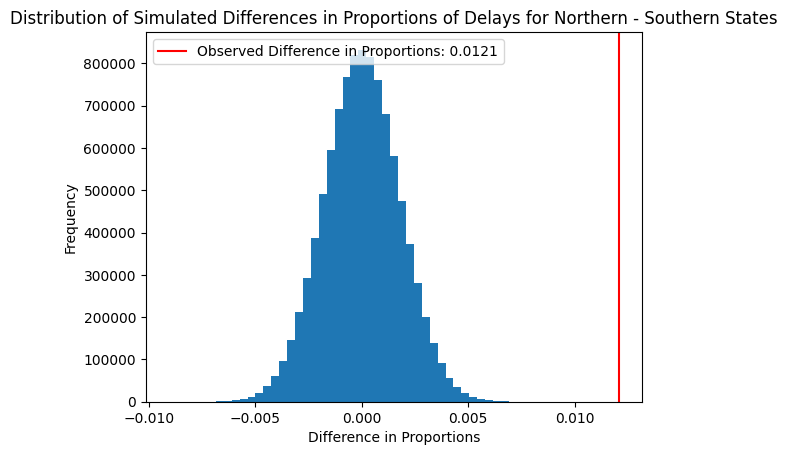

In [32]:
# Plot the distribution of simulated difference in proportions of delays for north vs. south states
_ = plt.hist(simulated_delays_north - simulated_delays_south, bins = 50)
plt.title("Distribution of Simulated Differences in Proportions of Delays for Northern - Southern States")
plt.xlabel("Difference in Proportions")
plt.ylabel("Frequency")
round_dpd = round(delay_proportion_diff1, 4)
plt.axvline(round_dpd, color = "red", label = "Observed Difference in Proportions: {}".format(round_dpd))
plt.legend()

### Hypothesis 3

For the third hypothesis, we want to test if Are some airlines significantly more likely to have delays than others? To do this, we will repeat the hypothesis test for separate airlines. We chose to consider the top three airlines by amount of flights in our dataset which are namely Southwest (WN), Delta (DL), and American (AA). In this case, rather than considering delays as a boolean, we are considering the actual number of minutes of delays. We choose the direction of the alternate (one-sided) hypothesis based on whether the observed average delay for that airline was greater than or less than the average for all flights. We formulate the hypothesis for American Airlines as follows (analogously for other airlines):\
\
In this data set American and Delta Airlines has lower than average delay, Southwest has higher than average delay.
Though these are all not statistically significant. It is possible that this is due to the effects of high outliers, but it is true that the observed averages don't deviate too much from the mean (9.0653, 11.0674, 7.7283 minutes respectively compared to the overall average of 9.9388)\
\
$H_0$: delay_AA - delay_avg = 0 (American Airlines has the same average delay as the average delay for all airlines)\
$H_1$: delay_AA - delay_avg < 0 (American Airlines has a lower average delay than the average delay for all airlines)

In [33]:
american = result_important_df.filter(pl.col('AIRLINE') == 'AA')
southwest = result_important_df.filter(pl.col('AIRLINE') == 'WN')
delta = result_important_df.filter(pl.col('AIRLINE') == 'DL')

In [34]:
# Calculate test statistics - average delay for American Airlines
aa_delay = american.select(pl.mean('DEPARTURE_DELAY'))[0, 0]

# Calculate mean (9.9388) and stdev (37.4972) for delay across all airlines
mean_delay = result_important_df.select(pl.mean('DEPARTURE_DELAY'))[0, 0]
stdev_delay = result_important_df.select(pl.std('DEPARTURE_DELAY'))[0, 0]

# Simulate the null world where American Airlines has same amount of delay, 10,000,000 trials
# I don't know if we can assume a Normal distribution but ok
simulated_delays = np.random.normal(mean_delay, stdev_delay, 10_000_000)
simulated_aa_delay = sum(simulated_delays) / len(simulated_delays)

# Calculate the p-value (p = 0.49077) this is > 0.05
simulated_p_value_aa = sum(x <= aa_delay for x in simulated_delays) / len(simulated_delays)
simulated_p_value_aa

0.4908401

Repeating the same for Southwest and Delta airlines, the other top airlines in this dataset

In [35]:
# Southwest Airlines
wn_delay = southwest.select(pl.mean('DEPARTURE_DELAY'))[0, 0]

# Calculate the p-value (p = 0.488225) this is > 0.05
simulated_p_value_wn = sum(x >= wn_delay for x in simulated_delays) / len(simulated_delays)
simulated_p_value_wn

0.4876573

In [36]:
# Delta Airlines
dl_delay = delta.select(pl.mean('DEPARTURE_DELAY'))[0, 0]

# Calculate the p-value (p = 0.4906998) this is > 0.05
simulated_p_value_dl = sum(x <= dl_delay for x in simulated_delays) / len(simulated_delays)
simulated_p_value_dl

0.4773188

With p-values of 0.49055 > 0.05, 0.488225 > 0.05, and 0.47657 > 0.05 we fail to reject $H_0$ that average delay for American Airlines, Southwest Airlines, and Delta Airlines are each significantly lower than average delay for all airlines. These are separate hypothesis tests, just writing them all in the same sentence.

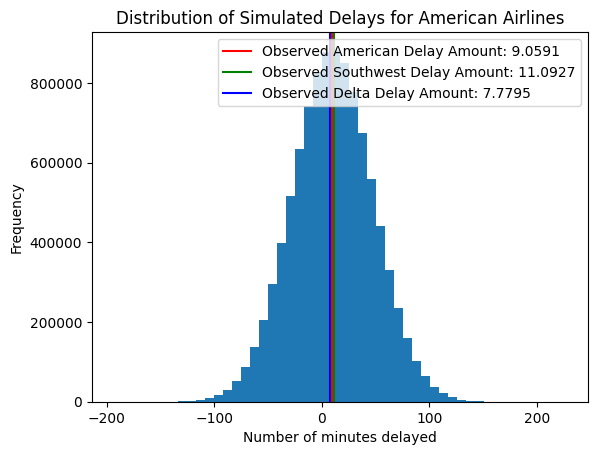

In [37]:
# Plot the distribution of simulated delay times for American Airlines
_ = plt.hist(simulated_delays, bins = 50)
plt.title("Distribution of Simulated Delays for American Airlines")
plt.xlabel("Number of minutes delayed")
plt.ylabel("Frequency")

round_aa = round(aa_delay, 4)
plt.axvline(round_aa, color = "red", label = "Observed American Delay Amount: {}".format(round_aa))

round_wn = round(wn_delay, 4)
plt.axvline(round_wn, color = "green", label = "Observed Southwest Delay Amount: {}".format(round_wn))

round_dl = round(dl_delay, 4)
plt.axvline(round_dl, color = "blue", label = "Observed Delta Delay Amount: {}".format(round_dl))

plt.legend()

# Part 5: Modeling

In [38]:
target = "DEPARTURE_DELAY"
print(result_important_df.filter(result_important_df[target] > 0).shape)
print(result_important_df.filter(result_important_df[target] <= 0).shape)

late_cutoff = 0

binary_results_df = result_important_df.with_columns(
    pl.when(result_important_df[target] > late_cutoff)
    .then(1)
    .otherwise(0)
    .alias("IS_DELAYED")  # Replace the column with the modified values
)
binary_results_df = binary_results_df
binary_results_df = binary_results_df.to_pandas()
#del result_important_df

(553427, 45)
(903399, 45)


In [39]:
binary_results_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY,region,IS_DELAYED
0,2015,3,2,1,WN,459,N902WN,ATL,BWI,1800,...,stable,2.509,8.124,5.316,1.445,1.058,9.684,100.0,southeast,1
1,2015,4,20,1,EV,4112,N11187,IAH,DSM,1540,...,stable,15.362,29.678,22.520,11.637,17.520,0.000,53.0,southwest,1
2,2015,7,15,3,UA,742,N419UA,DEN,OMA,2216,...,stable,13.796,31.057,22.427,4.988,17.427,0.135,27.0,southwest,1
3,2015,1,6,2,B6,62,N618JB,PBI,LGA,1045,...,stable,17.881,26.154,22.018,0.062,17.017,0.000,46.0,southeast,1
4,2015,3,28,6,AA,901,N4XCAA,DFW,PNS,1325,...,stable,7.415,21.363,14.389,0.000,9.389,2.534,-7.0,southwest,1


In [40]:
from sklearn.preprocessing import OneHotEncoder
numeric_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"]
target = ["IS_DELAYED"]
features_to_encode = ["AIRLINE"]
one_hot_encoder = OneHotEncoder(sparse_output = False)
encoded_binary_df = one_hot_encoder.fit_transform(binary_results_df[features_to_encode])
encoded_binary_df = pd.DataFrame(encoded_binary_df, columns=one_hot_encoder.get_feature_names_out(features_to_encode))
encoded_binary_df = pd.concat([encoded_binary_df, binary_results_df[numeric_features + target]], axis=1)

In [41]:
print(encoded_binary_df.shape)
encoded_binary_df = encoded_binary_df.dropna()
print(encoded_binary_df.shape)
encoded_binary_df.head()

(1480378, 28)
(1480376, 28)


,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,...,DAY,DAY_OF_WEEK,DISTANCE,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,IS_DELAYED
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,577,2.509,8.124,5.316,1.445,1.058,9.684,1
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,20,1,802,15.362,29.678,22.520,11.637,17.520,0.000,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15,3,472,13.796,31.057,22.427,4.988,17.427,0.135,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,2,1035,17.881,26.154,22.018,0.062,17.017,0.000,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,6,604,7.415,21.363,14.389,0.000,9.389,2.534,1


In [42]:
from sklearn.model_selection import train_test_split

#all_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"] + 

X = encoded_binary_df.drop('IS_DELAYED',axis = 1)
y = encoded_binary_df['IS_DELAYED']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1184300, 27)
(1184300,)
(296076, 27)


In [43]:
import torch
print(torch.tensor(y_test.values, dtype=torch.float32).mean().item())
print(torch.tensor(y_test.values, dtype=torch.float32).sum().item())
print(torch.tensor(y_test.values, dtype=torch.float32).size())

0.37326565384864807
110515.0
torch.Size([296076])


In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scalable_features = ['DISTANCE', 'tmin', 'tmax', 'tavg', 'ppt', 'dday_a5C','dday_b15C']

X_train_numeric = pd.DataFrame(scaler.fit_transform(X_train[scalable_features]),columns = scaler.get_feature_names_out(scalable_features))
X_train = pd.concat([X_train.drop(scalable_features,axis = 1).reset_index(drop=True),X_train_numeric.reset_index(drop=True)],axis = 1)
X_test_numeric = pd.DataFrame(scaler.transform(X_test[scalable_features]), columns = scaler.get_feature_names_out(scalable_features))
X_test = pd.concat([X_test.drop(scalable_features, axis = 1).reset_index(drop=True),X_test_numeric.reset_index(drop=True)], axis = 1)

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=10, random_state=42,verbose = 1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(clf.score(X_test,y_test))

0.6641605533714317


In [46]:
binary_results_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY,region,IS_DELAYED
0,2015,3,2,1,WN,459,N902WN,ATL,BWI,1800,...,stable,2.509,8.124,5.316,1.445,1.058,9.684,100.0,southeast,1
1,2015,4,20,1,EV,4112,N11187,IAH,DSM,1540,...,stable,15.362,29.678,22.520,11.637,17.520,0.000,53.0,southwest,1
2,2015,7,15,3,UA,742,N419UA,DEN,OMA,2216,...,stable,13.796,31.057,22.427,4.988,17.427,0.135,27.0,southwest,1
3,2015,1,6,2,B6,62,N618JB,PBI,LGA,1045,...,stable,17.881,26.154,22.018,0.062,17.017,0.000,46.0,southeast,1
4,2015,3,28,6,AA,901,N4XCAA,DFW,PNS,1325,...,stable,7.415,21.363,14.389,0.000,9.389,2.534,-7.0,southwest,1


In [47]:
from sklearn.preprocessing import OneHotEncoder
numeric_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"]
target = ["IS_DELAYED"]
features_to_encode = ["AIRLINE"]
one_hot_encoder = OneHotEncoder(sparse_output = False)
encoded_binary_df = one_hot_encoder.fit_transform(binary_results_df[features_to_encode])
encoded_binary_df = pd.DataFrame(encoded_binary_df, columns=one_hot_encoder.get_feature_names_out(features_to_encode))
encoded_binary_df = pd.concat([encoded_binary_df, binary_results_df[numeric_features + target]], axis=1)

In [48]:
encoded_binary_df

,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,...,DAY,DAY_OF_WEEK,DISTANCE,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,IS_DELAYED
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,577,2.509,8.124,5.316,1.445,1.058,9.684,1
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,20,1,802,15.362,29.678,22.520,11.637,17.520,0.000,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15,3,472,13.796,31.057,22.427,4.988,17.427,0.135,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,2,1035,17.881,26.154,22.018,0.062,17.017,0.000,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,6,604,7.415,21.363,14.389,0.000,9.389,2.534,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,29,7,109,10.428,28.597,19.512,0.000,14.512,1.001,1
1480374,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20,7,2079,-5.675,-0.322,-2.999,0.000,0.000,17.999,1
1480375,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14,2,223,18.283,28.108,23.196,1.011,18.195,0.000,0
1480376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,24,7,255,9.991,20.965,15.478,0.000,10.478,1.514,0


In [49]:
print(encoded_binary_df.shape)
encoded_binary_df = encoded_binary_df.dropna()
print(encoded_binary_df.shape)
encoded_binary_df.head()

(1480378, 28)
(1480376, 28)


,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,...,DAY,DAY_OF_WEEK,DISTANCE,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,IS_DELAYED
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,1,577,2.509,8.124,5.316,1.445,1.058,9.684,1
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,20,1,802,15.362,29.678,22.520,11.637,17.520,0.000,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15,3,472,13.796,31.057,22.427,4.988,17.427,0.135,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,2,1035,17.881,26.154,22.018,0.062,17.017,0.000,1
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28,6,604,7.415,21.363,14.389,0.000,9.389,2.534,1


In [50]:
from sklearn.model_selection import train_test_split

#all_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"] + 

X = encoded_binary_df.drop('IS_DELAYED',axis = 1)
y = encoded_binary_df['IS_DELAYED']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(1184300, 27)
(1184300,)
(296076, 27)


In [51]:
import torch
print(torch.tensor(y_test.values, dtype=torch.float32).mean().item())
print(torch.tensor(y_test.values, dtype=torch.float32).sum().item())
print(torch.tensor(y_test.values, dtype=torch.float32).size())

0.37326565384864807
110515.0
torch.Size([296076])


In [52]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scalable_features = ['DISTANCE', 'tmin', 'tmax', 'tavg', 'ppt', 'dday_a5C','dday_b15C']

X_train_numeric = pd.DataFrame(scaler.fit_transform(X_train[scalable_features]),columns = scaler.get_feature_names_out(scalable_features))
X_train = pd.concat([X_train.drop(scalable_features,axis = 1).reset_index(drop=True),X_train_numeric.reset_index(drop=True)],axis = 1)
X_test_numeric = pd.DataFrame(scaler.transform(X_test[scalable_features]), columns = scaler.get_feature_names_out(scalable_features))
X_test = pd.concat([X_test.drop(scalable_features, axis = 1).reset_index(drop=True),X_test_numeric.reset_index(drop=True)], axis = 1)

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=10, random_state=42,verbose = 1)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(clf.score(X_test,y_test))

0.6641605533714317


In [54]:
feature_importances = clf.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AIRLINE_AA, Importance: 0.0049
Feature: AIRLINE_AS, Importance: 0.0021
Feature: AIRLINE_B6, Importance: 0.0029
Feature: AIRLINE_DL, Importance: 0.0054
Feature: AIRLINE_EV, Importance: 0.0042
Feature: AIRLINE_F9, Importance: 0.0020
Feature: AIRLINE_HA, Importance: 0.0002
Feature: AIRLINE_MQ, Importance: 0.0034
Feature: AIRLINE_NK, Importance: 0.0025
Feature: AIRLINE_OO, Importance: 0.0042
Feature: AIRLINE_UA, Importance: 0.0076
Feature: AIRLINE_US, Importance: 0.0025
Feature: AIRLINE_VX, Importance: 0.0014
Feature: AIRLINE_WN, Importance: 0.0119
Feature: SCHEDULED_DEPARTURE, Importance: 0.1859
Feature: SCHEDULED_TIME, Importance: 0.1214
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0353
Feature: DAY, Importance: 0.0607
Feature: DAY_OF_WEEK, Importance: 0.0368
Feature: DISTANCE, Importance: 0.1235
Feature: tmin, Importance: 0.0747
Feature: tmax, Importance: 0.0742
Feature: tavg, Importance: 0.0696
Feature: ppt, Importance: 0.0507
Feature: dday_a5C, Importance: 

In [55]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
forest_preds = y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, forest_preds)
recall = recall_score(all_labels, forest_preds)
f1 = f1_score(all_labels, forest_preds)
accuracy = accuracy_score(all_labels, forest_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.5749
Recall: 0.3849
F1-Score: 0.4611
Accuracy: 0.6642


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, 128)   # First fully connected layer
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)           # Second fully connected layer
        self.fc4 = nn.Linear(64, 1)            # Output layer (binary output)
        self.sigmoid = nn.Sigmoid()            # Sigmoid activation for binary output

    def forward(self, x):
        # Forward pass through the network
        x = torch.relu(self.fc1(x))  # ReLU activation for hidden layer
        x = torch.relu(self.fc2(x))  # ReLU activation for hidden layer
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  # Sigmoid activation for binary output
        return x

In [57]:
from torch.utils.data import DataLoader, TensorDataset

model = SimpleNN(len(X_train.columns))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model.train()  # Set model to training mode
epochs = 10
y_train = y_train.astype(float)
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for i in range(epochs):
  model.train()  # Set the model to training mode
  running_loss = 0.0

  for batch_idx, (inputs, labels) in enumerate(train_loader):
    optimizer.zero_grad()  # Zero the gradients
        
    # Forward pass
    outputs = model(inputs)

    if torch.isnan(outputs).any():
      print("NaN detected in outputs!")
      break
    
    #print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    #print(f"Outputs shape: {outputs.shape}, Outputs (sample): {outputs[:5]}")  # Print the first 5 output values
    #print(f"Labels (sample): {labels[:5]}")

    # Compute the loss
    loss = criterion(outputs.squeeze(dim = 1), labels)
    running_loss += loss.item()

    # Backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Update the model weights
    optimizer.step()

  # Print the average loss for this epoch
  avg_loss = running_loss / len(train_loader)
  print(f"Epoch [{i+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.6407
Epoch [2/10], Loss: 0.6246
Epoch [3/10], Loss: 0.6237
Epoch [4/10], Loss: 0.6234
Epoch [5/10], Loss: 0.6235
Epoch [6/10], Loss: 0.6230
Epoch [7/10], Loss: 0.6233
Epoch [8/10], Loss: 0.6230
Epoch [9/10], Loss: 0.6230
Epoch [10/10], Loss: 0.6232


In [58]:
model.eval()

test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation during testing
    for inputs, labels in test_loader:
        # Forward pass: Compute predicted y by passing X_test to the model
        outputs = model(inputs).squeeze(dim = 1)
        
        # Apply threshold to get binary predictions
        predicted = (outputs >= 0.5).float()
        
        # Count the number of correct predictions
        all_preds.append(predicted.squeeze().cpu().numpy())  # Convert to numpy for sklearn
        all_labels.append(labels.squeeze().cpu().numpy())


all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

#calcualte metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.5506
Recall: 0.4328
F1-Score: 0.4847
Accuracy: 0.6564


In [59]:
1 - torch.tensor(y_test.values, dtype=torch.float32).mean().item()

0.6267343461513519

In [60]:
import xgboost as xgb

xgbClassifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state = 42)
xgbClassifier.fit(X_train,y_train)

xgb_y_pred = xgbClassifier.predict(X_test)

print(xgbClassifier.score(X_train,y_train))
print(xgbClassifier.score(X_test,y_test))

0.6925652284049649
0.6878943244302138


In [61]:
feature_importances = xgbClassifier.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AIRLINE_AA, Importance: 0.0081
Feature: AIRLINE_AS, Importance: 0.0529
Feature: AIRLINE_B6, Importance: 0.0271
Feature: AIRLINE_DL, Importance: 0.0128
Feature: AIRLINE_EV, Importance: 0.0193
Feature: AIRLINE_F9, Importance: 0.0158
Feature: AIRLINE_HA, Importance: 0.0113
Feature: AIRLINE_MQ, Importance: 0.0148
Feature: AIRLINE_NK, Importance: 0.0519
Feature: AIRLINE_OO, Importance: 0.0144
Feature: AIRLINE_UA, Importance: 0.2684
Feature: AIRLINE_US, Importance: 0.0136
Feature: AIRLINE_VX, Importance: 0.0161
Feature: AIRLINE_WN, Importance: 0.2027
Feature: SCHEDULED_DEPARTURE, Importance: 0.0810
Feature: SCHEDULED_TIME, Importance: 0.0116
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0375
Feature: DAY, Importance: 0.0231
Feature: DAY_OF_WEEK, Importance: 0.0159
Feature: DISTANCE, Importance: 0.0173
Feature: tmin, Importance: 0.0161
Feature: tmax, Importance: 0.0119
Feature: tavg, Importance: 0.0107
Feature: ppt, Importance: 0.0229
Feature: dday_a5C, Importance: 

In [62]:
all_preds = xgb_y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6328
Recall: 0.3904
F1-Score: 0.4829
Accuracy: 0.6879


In [63]:
import xgboost as xgb

xgbClassifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state = 42)
xgbClassifier.fit(X_train,y_train)

xgb_y_pred = xgbClassifier.predict(X_test)

print(xgbClassifier.score(X_train,y_train))
print(xgbClassifier.score(X_test,y_test))

0.6925652284049649
0.6878943244302138


In [64]:
feature_importances = xgbClassifier.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AIRLINE_AA, Importance: 0.0081
Feature: AIRLINE_AS, Importance: 0.0529
Feature: AIRLINE_B6, Importance: 0.0271
Feature: AIRLINE_DL, Importance: 0.0128
Feature: AIRLINE_EV, Importance: 0.0193
Feature: AIRLINE_F9, Importance: 0.0158
Feature: AIRLINE_HA, Importance: 0.0113
Feature: AIRLINE_MQ, Importance: 0.0148
Feature: AIRLINE_NK, Importance: 0.0519
Feature: AIRLINE_OO, Importance: 0.0144
Feature: AIRLINE_UA, Importance: 0.2684
Feature: AIRLINE_US, Importance: 0.0136
Feature: AIRLINE_VX, Importance: 0.0161
Feature: AIRLINE_WN, Importance: 0.2027
Feature: SCHEDULED_DEPARTURE, Importance: 0.0810
Feature: SCHEDULED_TIME, Importance: 0.0116
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0375
Feature: DAY, Importance: 0.0231
Feature: DAY_OF_WEEK, Importance: 0.0159
Feature: DISTANCE, Importance: 0.0173
Feature: tmin, Importance: 0.0161
Feature: tmax, Importance: 0.0119
Feature: tavg, Importance: 0.0107
Feature: ppt, Importance: 0.0229
Feature: dday_a5C, Importance: 

In [65]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
all_preds = xgb_y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6328
Recall: 0.3904
F1-Score: 0.4829
Accuracy: 0.6879


In [66]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


xgb = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 7],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5],
    'gamma': [1, 2],
}


grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=2,
    verbose=2,
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   1.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   1.8s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   3.0s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   2.9s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, n_estimators=50; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, n_estimators=50; total time=   1.3s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child

In [67]:
forest_preds = y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, forest_preds)
recall = recall_score(all_labels, forest_preds)
f1 = f1_score(all_labels, forest_preds)
accuracy = accuracy_score(all_labels, forest_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6343
Recall: 0.3975
F1-Score: 0.4887
Accuracy: 0.6896


In [68]:
import xgboost as xgb

xgbClassifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state = 42)
xgbClassifier.fit(X_train,y_train)

xgb_y_pred = xgbClassifier.predict(X_test)

print(xgbClassifier.score(X_train,y_train))
print(xgbClassifier.score(X_test,y_test))

0.6925652284049649
0.6878943244302138


In [69]:
feature_importances = xgbClassifier.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AIRLINE_AA, Importance: 0.0081
Feature: AIRLINE_AS, Importance: 0.0529
Feature: AIRLINE_B6, Importance: 0.0271
Feature: AIRLINE_DL, Importance: 0.0128
Feature: AIRLINE_EV, Importance: 0.0193
Feature: AIRLINE_F9, Importance: 0.0158
Feature: AIRLINE_HA, Importance: 0.0113
Feature: AIRLINE_MQ, Importance: 0.0148
Feature: AIRLINE_NK, Importance: 0.0519
Feature: AIRLINE_OO, Importance: 0.0144
Feature: AIRLINE_UA, Importance: 0.2684
Feature: AIRLINE_US, Importance: 0.0136
Feature: AIRLINE_VX, Importance: 0.0161
Feature: AIRLINE_WN, Importance: 0.2027
Feature: SCHEDULED_DEPARTURE, Importance: 0.0810
Feature: SCHEDULED_TIME, Importance: 0.0116
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0375
Feature: DAY, Importance: 0.0231
Feature: DAY_OF_WEEK, Importance: 0.0159
Feature: DISTANCE, Importance: 0.0173
Feature: tmin, Importance: 0.0161
Feature: tmax, Importance: 0.0119
Feature: tavg, Importance: 0.0107
Feature: ppt, Importance: 0.0229
Feature: dday_a5C, Importance: 

In [70]:
from sklearn.preprocessing import OneHotEncoder
numeric_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"]
target = ["IS_DELAYED"]
features_to_encode = ["AIRLINE"]
one_hot_encoder = OneHotEncoder(sparse_output = False)
encoded_binary_df = one_hot_encoder.fit_transform(binary_results_df[features_to_encode])
encoded_binary_df = pd.DataFrame(encoded_binary_df, columns=one_hot_encoder.get_feature_names_out(features_to_encode))
encoded_binary_df = pd.concat([encoded_binary_df, binary_results_df[numeric_features + target]], axis=1)

In [71]:
import xgboost as xgb

xgbClassifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state = 42)
xgbClassifier.fit(X_train,y_train)

xgb_y_pred = xgbClassifier.predict(X_test)

print(xgbClassifier.score(X_train,y_train))
print(xgbClassifier.score(X_test,y_test))

0.6925652284049649
0.6878943244302138


In [72]:
feature_importances = xgbClassifier.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AIRLINE_AA, Importance: 0.0081
Feature: AIRLINE_AS, Importance: 0.0529
Feature: AIRLINE_B6, Importance: 0.0271
Feature: AIRLINE_DL, Importance: 0.0128
Feature: AIRLINE_EV, Importance: 0.0193
Feature: AIRLINE_F9, Importance: 0.0158
Feature: AIRLINE_HA, Importance: 0.0113
Feature: AIRLINE_MQ, Importance: 0.0148
Feature: AIRLINE_NK, Importance: 0.0519
Feature: AIRLINE_OO, Importance: 0.0144
Feature: AIRLINE_UA, Importance: 0.2684
Feature: AIRLINE_US, Importance: 0.0136
Feature: AIRLINE_VX, Importance: 0.0161
Feature: AIRLINE_WN, Importance: 0.2027
Feature: SCHEDULED_DEPARTURE, Importance: 0.0810
Feature: SCHEDULED_TIME, Importance: 0.0116
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0375
Feature: DAY, Importance: 0.0231
Feature: DAY_OF_WEEK, Importance: 0.0159
Feature: DISTANCE, Importance: 0.0173
Feature: tmin, Importance: 0.0161
Feature: tmax, Importance: 0.0119
Feature: tavg, Importance: 0.0107
Feature: ppt, Importance: 0.0229
Feature: dday_a5C, Importance: 

In [73]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
all_preds = xgb_y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6328
Recall: 0.3904
F1-Score: 0.4829
Accuracy: 0.6879


In [74]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


xgb = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 7],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5],
    'gamma': [1, 2],
}


grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=2,
    verbose=2,
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   1.6s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   2.1s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   3.1s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   3.2s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, n_estimators=50; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, n_estimators=50; total time=   1.5s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child

In [75]:
forest_preds = y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, forest_preds)
recall = recall_score(all_labels, forest_preds)
f1 = f1_score(all_labels, forest_preds)
accuracy = accuracy_score(all_labels, forest_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.6343
Recall: 0.3975
F1-Score: 0.4887
Accuracy: 0.6896


One thing we notice is that our model is terrible, this probably has to do with the fact that when flights are delayed by 1-2 mins, it is much harder to predict as 1-2 minute delay is basically nothing. The factors that influence this could just be beuracracy. Thus we will try again, but set a threshold of a delayed flight at 15 minutes.

In [76]:
target = "DEPARTURE_DELAY"
print(result_important_df.filter(result_important_df[target] > 0).shape)
print(result_important_df.filter(result_important_df[target] <= 0).shape)

late_cutoff = 15

binary_results_df = result_important_df.with_columns(
    pl.when(result_important_df[target] > late_cutoff)
    .then(1)
    .otherwise(0)
    .alias("IS_DELAYED")  # Replace the column with the modified values
)
binary_results_df = binary_results_df.sample(fraction = 0.3,seed =42)
binary_results_df = binary_results_df.to_pandas()
#del result_important_df

(553427, 45)
(903399, 45)


In [77]:
binary_results_df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,stability,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,TOTAL_DELAY,region,IS_DELAYED
0,2015,6,1,1,OO,6492,N934SW,DEN,COD,1901,...,stable,11.932,29.438,20.685,0.123,15.685,0.555,20.0,southwest,0
1,2015,1,5,1,WN,51,N520SW,HOU,HRL,2035,...,stable,0.063,11.694,5.878,0.000,2.312,9.122,24.0,southwest,0
2,2015,6,6,6,OO,7382,N781CA,CPR,SLC,615,...,stable,10.335,22.066,16.200,3.406,11.200,1.307,-21.0,northwest,0
3,2015,4,23,4,B6,1109,N273JB,BOS,JAX,845,...,stable,4.835,19.584,12.209,0.160,7.217,3.913,76.0,newengland,1
4,2015,4,7,2,DL,2489,N904DA,PHL,DTW,600,...,stable,7.270,23.004,15.137,0.074,10.137,2.436,-22.0,midatlantic,0


In [78]:
from sklearn.preprocessing import OneHotEncoder
numeric_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"]
target = ["IS_DELAYED"]
features_to_encode = ["AIRLINE"]
one_hot_encoder = OneHotEncoder(sparse_output = False)
encoded_binary_df = one_hot_encoder.fit_transform(binary_results_df[features_to_encode])
encoded_binary_df = pd.DataFrame(encoded_binary_df, columns=one_hot_encoder.get_feature_names_out(features_to_encode))
encoded_binary_df = pd.concat([encoded_binary_df, binary_results_df[numeric_features + target]], axis=1)

In [79]:
print(encoded_binary_df.shape)
encoded_binary_df = encoded_binary_df.dropna()
print(encoded_binary_df.shape)
encoded_binary_df.head()

(444113, 28)
(444112, 28)


,AIRLINE_AA,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_EV,AIRLINE_F9,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OO,...,DAY,DAY_OF_WEEK,DISTANCE,tmin,tmax,tavg,ppt,dday_a5C,dday_b15C,IS_DELAYED
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1,1,391,11.932,29.438,20.685,0.123,15.685,0.555,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5,1,277,0.063,11.694,5.878,0.000,2.312,9.122,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,6,6,320,10.335,22.066,16.200,3.406,11.200,1.307,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,23,4,1010,4.835,19.584,12.209,0.160,7.217,3.913,1
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7,2,453,7.270,23.004,15.137,0.074,10.137,2.436,0


In [80]:
from sklearn.model_selection import train_test_split

#all_features = ["SCHEDULED_DEPARTURE", "SCHEDULED_TIME","YEAR","MONTH","DAY","DAY_OF_WEEK","DISTANCE","tmin","tmax","tavg","ppt","dday_a5C","dday_b15C"] + 

X = encoded_binary_df.drop('IS_DELAYED',axis = 1)
y = encoded_binary_df['IS_DELAYED']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(355289, 27)
(355289,)
(88823, 27)


In [81]:
import torch
print(torch.tensor(y_test.values, dtype=torch.float32).mean().item())
print(torch.tensor(y_test.values, dtype=torch.float32).sum().item())
print(torch.tensor(y_test.values, dtype=torch.float32).size())

0.18379248678684235
16325.0
torch.Size([88823])


In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scalable_features = ['DISTANCE', 'tmin', 'tmax', 'tavg', 'ppt', 'dday_a5C','dday_b15C']

X_train_numeric = pd.DataFrame(scaler.fit_transform(X_train[scalable_features]),columns = scaler.get_feature_names_out(scalable_features))
X_train = pd.concat([X_train.drop(scalable_features,axis = 1).reset_index(drop=True),X_train_numeric.reset_index(drop=True)],axis = 1)
X_test_numeric = pd.DataFrame(scaler.transform(X_test[scalable_features]), columns = scaler.get_feature_names_out(scalable_features))
X_test = pd.concat([X_test.drop(scalable_features, axis = 1).reset_index(drop=True),X_test_numeric.reset_index(drop=True)], axis = 1)

In [83]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


clf = RandomForestClassifier(n_estimators=50, random_state=42,verbose = 1,class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(clf.score(X_test,y_test))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   47.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


0.8163989056888419


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


In [84]:
feature_importances = clf.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AIRLINE_AA, Importance: 0.0068
Feature: AIRLINE_AS, Importance: 0.0025
Feature: AIRLINE_B6, Importance: 0.0042
Feature: AIRLINE_DL, Importance: 0.0063
Feature: AIRLINE_EV, Importance: 0.0060
Feature: AIRLINE_F9, Importance: 0.0028
Feature: AIRLINE_HA, Importance: 0.0002
Feature: AIRLINE_MQ, Importance: 0.0048
Feature: AIRLINE_NK, Importance: 0.0033
Feature: AIRLINE_OO, Importance: 0.0057
Feature: AIRLINE_UA, Importance: 0.0056
Feature: AIRLINE_US, Importance: 0.0032
Feature: AIRLINE_VX, Importance: 0.0017
Feature: AIRLINE_WN, Importance: 0.0078
Feature: SCHEDULED_DEPARTURE, Importance: 0.1778
Feature: SCHEDULED_TIME, Importance: 0.1094
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0377
Feature: DAY, Importance: 0.0649
Feature: DAY_OF_WEEK, Importance: 0.0382
Feature: DISTANCE, Importance: 0.1131
Feature: tmin, Importance: 0.0783
Feature: tmax, Importance: 0.0774
Feature: tavg, Importance: 0.0722
Feature: ppt, Importance: 0.0553
Feature: dday_a5C, Importance: 

In [85]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
forest_preds = y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, forest_preds)
recall = recall_score(all_labels, forest_preds)
f1 = f1_score(all_labels, forest_preds)
accuracy = accuracy_score(all_labels, forest_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.5021
Recall: 0.1272
F1-Score: 0.2030
Accuracy: 0.8164


In [86]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, 128)   # First fully connected layer
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)           # Second fully connected layer
        self.fc4 = nn.Linear(64, 1)            # Output layer (binary output)
        self.sigmoid = nn.Sigmoid()            # Sigmoid activation for binary output

    def forward(self, x):
        # Forward pass through the network
        x = torch.relu(self.fc1(x))  # ReLU activation for hidden layer
        x = torch.relu(self.fc2(x))  # ReLU activation for hidden layer
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  # Sigmoid activation for binary output
        return x

In [87]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scalable_features = ['DISTANCE', 'tmin', 'tmax', 'tavg', 'ppt', 'dday_a5C','dday_b15C']

X_train_numeric = pd.DataFrame(scaler.fit_transform(X_train[scalable_features]),columns = scaler.get_feature_names_out(scalable_features))
X_train = pd.concat([X_train.drop(scalable_features,axis = 1).reset_index(drop=True),X_train_numeric.reset_index(drop=True)],axis = 1)
X_test_numeric = pd.DataFrame(scaler.transform(X_test[scalable_features]), columns = scaler.get_feature_names_out(scalable_features))
X_test = pd.concat([X_test.drop(scalable_features, axis = 1).reset_index(drop=True),X_test_numeric.reset_index(drop=True)], axis = 1)

In [88]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


clf = RandomForestClassifier(n_estimators=50, random_state=42,verbose = 1,class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(clf.score(X_test,y_test))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   45.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.2s


0.8163989056888419


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.3s


In [89]:
feature_importances = clf.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AIRLINE_AA, Importance: 0.0068
Feature: AIRLINE_AS, Importance: 0.0025
Feature: AIRLINE_B6, Importance: 0.0042
Feature: AIRLINE_DL, Importance: 0.0063
Feature: AIRLINE_EV, Importance: 0.0060
Feature: AIRLINE_F9, Importance: 0.0028
Feature: AIRLINE_HA, Importance: 0.0002
Feature: AIRLINE_MQ, Importance: 0.0048
Feature: AIRLINE_NK, Importance: 0.0033
Feature: AIRLINE_OO, Importance: 0.0057
Feature: AIRLINE_UA, Importance: 0.0056
Feature: AIRLINE_US, Importance: 0.0032
Feature: AIRLINE_VX, Importance: 0.0017
Feature: AIRLINE_WN, Importance: 0.0078
Feature: SCHEDULED_DEPARTURE, Importance: 0.1778
Feature: SCHEDULED_TIME, Importance: 0.1094
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0377
Feature: DAY, Importance: 0.0649
Feature: DAY_OF_WEEK, Importance: 0.0382
Feature: DISTANCE, Importance: 0.1131
Feature: tmin, Importance: 0.0783
Feature: tmax, Importance: 0.0774
Feature: tavg, Importance: 0.0722
Feature: ppt, Importance: 0.0553
Feature: dday_a5C, Importance: 

In [90]:
from sklearn.metrics import f1_score, accuracy_score,precision_score, recall_score
forest_preds = y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, forest_preds)
recall = recall_score(all_labels, forest_preds)
f1 = f1_score(all_labels, forest_preds)
accuracy = accuracy_score(all_labels, forest_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.5021
Recall: 0.1272
F1-Score: 0.2030
Accuracy: 0.8164


In [91]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        # Define the layers
        self.fc1 = nn.Linear(input_size, 128)   # First fully connected layer
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)           # Second fully connected layer
        self.fc4 = nn.Linear(64, 1)            # Output layer (binary output)
        self.sigmoid = nn.Sigmoid()            # Sigmoid activation for binary output

    def forward(self, x):
        # Forward pass through the network
        x = torch.relu(self.fc1(x))  # ReLU activation for hidden layer
        x = torch.relu(self.fc2(x))  # ReLU activation for hidden layer
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))  # Sigmoid activation for binary output
        return x

In [92]:
from torch.utils.data import DataLoader, TensorDataset

model = SimpleNN(len(X_train.columns))
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model.train()  # Set model to training mode
epochs = 10
y_train = y_train.astype(float)
train_dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
for i in range(epochs):
  model.train()  # Set the model to training mode
  running_loss = 0.0

  for batch_idx, (inputs, labels) in enumerate(train_loader):
    optimizer.zero_grad()  # Zero the gradients
        
    # Forward pass
    outputs = model(inputs)

    if torch.isnan(outputs).any():
      print("NaN detected in outputs!")
      break
    
    #print(f"Inputs shape: {inputs.shape}, Labels shape: {labels.shape}")
    #print(f"Outputs shape: {outputs.shape}, Outputs (sample): {outputs[:5]}")  # Print the first 5 output values
    #print(f"Labels (sample): {labels[:5]}")

    # Compute the loss
    loss = criterion(outputs.squeeze(dim = 1), labels)
    running_loss += loss.item()

    # Backward pass
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # Update the model weights
    optimizer.step()

  # Print the average loss for this epoch
  avg_loss = running_loss / len(train_loader)
  print(f"Epoch [{i+1}/{epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.4787
Epoch [2/10], Loss: 0.4580
Epoch [3/10], Loss: 0.4555
Epoch [4/10], Loss: 0.4540
Epoch [5/10], Loss: 0.4532
Epoch [6/10], Loss: 0.4525
Epoch [7/10], Loss: 0.4524
Epoch [8/10], Loss: 0.4521
Epoch [9/10], Loss: 0.4517
Epoch [10/10], Loss: 0.4520


In [93]:
model.eval()

test_dataset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient computation during testing
    for inputs, labels in test_loader:
        # Forward pass: Compute predicted y by passing X_test to the model
        outputs = model(inputs).squeeze(dim = 1)
        
        # Apply threshold to get binary predictions
        predicted = (outputs >= 0.5).float()
        
        # Count the number of correct predictions
        all_preds.append(predicted.squeeze().cpu().numpy())  # Convert to numpy for sklearn
        all_labels.append(labels.squeeze().cpu().numpy())


all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

#calcualte metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Accuracy: 0.8162


c:\Users\nball\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [94]:
1 - torch.tensor(y_test.values, dtype=torch.float32).mean().item()

0.8162075132131577

In [95]:
import xgboost as xgb

xgbClassifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state = 42)
xgbClassifier.fit(X_train,y_train)

xgb_y_pred = xgbClassifier.predict(X_test)

print(xgbClassifier.score(X_train,y_train))
print(xgbClassifier.score(X_test,y_test))

0.8281033187067429
0.8200916429303221


In [96]:
feature_importances = xgbClassifier.feature_importances_
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AIRLINE_AA, Importance: 0.0150
Feature: AIRLINE_AS, Importance: 0.0847
Feature: AIRLINE_B6, Importance: 0.0389
Feature: AIRLINE_DL, Importance: 0.0544
Feature: AIRLINE_EV, Importance: 0.0241
Feature: AIRLINE_F9, Importance: 0.0335
Feature: AIRLINE_HA, Importance: 0.0132
Feature: AIRLINE_MQ, Importance: 0.0292
Feature: AIRLINE_NK, Importance: 0.0610
Feature: AIRLINE_OO, Importance: 0.0266
Feature: AIRLINE_UA, Importance: 0.0924
Feature: AIRLINE_US, Importance: 0.0329
Feature: AIRLINE_VX, Importance: 0.0202
Feature: AIRLINE_WN, Importance: 0.0926
Feature: SCHEDULED_DEPARTURE, Importance: 0.0824
Feature: SCHEDULED_TIME, Importance: 0.0155
Feature: YEAR, Importance: 0.0000
Feature: MONTH, Importance: 0.0477
Feature: DAY, Importance: 0.0347
Feature: DAY_OF_WEEK, Importance: 0.0283
Feature: DISTANCE, Importance: 0.0177
Feature: tmin, Importance: 0.0268
Feature: tmax, Importance: 0.0217
Feature: tavg, Importance: 0.0242
Feature: ppt, Importance: 0.0355
Feature: dday_a5C, Importance: 

In [97]:
all_preds = xgb_y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
accuracy = accuracy_score(all_labels, all_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.5809
Recall: 0.0759
F1-Score: 0.1343
Accuracy: 0.8201


In [98]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score


xgb = XGBClassifier(random_state=42, use_label_encoder=True, eval_metric='logloss')

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 7],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5],
    'gamma': [1, 2],
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=2,
    verbose=2,
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Best Parameters:", best_params)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=50; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.6s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=100; total time=   0.7s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.8s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=1, n_estimators=200; total time=   0.8s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, n_estimators=50; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child_weight=5, n_estimators=50; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=1, max_depth=3, min_child

In [99]:
from sklearn.metrics import balanced_accuracy_score

print("Test Accuracy:", balanced_accuracy_score(y_test, y_pred))

Test Accuracy: 0.5285385734039577


In [100]:
forest_preds = y_pred
all_labels = y_test.to_numpy()

#calcualte metrics
precision = precision_score(all_labels, forest_preds)
recall = recall_score(all_labels, forest_preds)
f1 = f1_score(all_labels, forest_preds)
accuracy = accuracy_score(all_labels, forest_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Precision: 0.5849
Recall: 0.0679
F1-Score: 0.1217
Accuracy: 0.8198


OVERSAMPLING!

In [101]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = encoded_binary_df.drop('IS_DELAYED',axis = 1)
y = encoded_binary_df['IS_DELAYED']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("Resampled class distribution:\n", pd.Series(y_train_smote).value_counts())

# Train a classifier on the resampled data
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Evaluate on the test set
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

Original class distribution:
 IS_DELAYED
0    290300
1     64989
Name: count, dtype: int64
Resampled class distribution:
 IS_DELAYED
1    290300
0    290300
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.84      0.92      0.88     72498
           1       0.41      0.24      0.30     16325

    accuracy                           0.80     88823
   macro avg       0.63      0.58      0.59     88823
weighted avg       0.76      0.80      0.77     88823

